In [107]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import glob as glob
import scipy.stats as sp

import matplotlib
from matplotlib import rc
font = {'size'   : 16}
matplotlib.rc('font', **font)
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
#rc('text', usetex=True)

# change font
matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['font.family'] = "sans-serif"
sns.set_style("whitegrid")

In [108]:
import matplotlib.style as style
style.available

['Solarize_Light2',
 '_classic_test_patch',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

In [109]:
#style.use('seaborn-poster') #sets the size of the charts
#style.use('seaborn-whitegrid')

# Plots A - E : MCC / AUC of binary classification

In [110]:
def calculate_stats(df):
    for col in df.columns:
        if col == 'scr':
            continue
        vals = df[col]
        orig = list(vals[df['scr'] == 'Original'])
        scr = list(vals[df['scr'] == 'Scrambled'])
        print(col)
        print(sp.ttest_ind(orig, scr))

def calc_mcc(folder, seq, val_name):
    folds = ['outputs/autokeras/binary_classification/', 'outputs/deepswarm/binary_classification/', 'outputs/tpot/binary_classification/']
    mcc = pd.DataFrame()
    file_name = 'all_results.txt'
    for fold in folds:
        name = fold.split('outputs/')[1].split('/binary_classification')[0]
        name = name.replace('deepswarm', 'DeepSwarm')
        name = name.replace('autokeras', 'AutoKeras')
        name = name.replace('tpot', 'TPOT')

        df = pd.read_csv(folder + seq + fold + file_name, sep = '\t', header = None)
        vals = df.values
        for i in range(len(vals)):
            val = vals[i]
            if val_name in val[0]:
                new = val[0].split(": ")[1]
                new = new.strip("[")
                new = new.strip("]")

                new = [s for s in new.split(' ')]
                new = [s for s in new if s != '']
                new = [0 if s == '0.' else s for s in new]
                new = [float(s) for s in new]
                mcc[name] = new
    mcc['scr'] = ['Original'] * len(mcc)
    
    file_name = 'all_scrambled_control_results.txt'
    scr_mcc = pd.DataFrame()
    for fold in folds:
        name = fold.split('outputs/')[1].split('/binary_classification')[0]
        name = name.replace('deepswarm', 'DeepSwarm')
        name = name.replace('autokeras', 'AutoKeras')
        name = name.replace('tpot', 'TPOT')
        df = pd.read_csv(folder + seq + fold + 'scrambled/' + file_name, sep = '\t', header = None)
        vals = df.values
        for i in range(len(vals)):
            val = vals[i]
            if val_name in val[0]:
                new = val[0].split(": ")[1]
                new = new.strip("[")
                new = new.strip("]")

                new = [s for s in new.split(' ')]
                new = [s for s in new if s != '']
                new = [0 if s == '0.' else s for s in new]
                new = [float(s) for s in new]
                scr_mcc[name] = new
    scr_mcc['scr'] = ['Scrambled'] * len(scr_mcc)
    mcc = pd.concat([mcc, scr_mcc])
    
    print('Running statistics now...')
    calculate_stats(mcc)

    return(mcc)

In [111]:
def reshape(df):
    new = pd.DataFrame()
    new['model_type'] = []
    index = 0
    for name, col in df.iteritems():
        if 'scr' in name:
            continue
        new_pd = pd.DataFrame(col)
        new_pd.columns = ['values']
        new_pd['scr'] = list(df['scr'])
        new_pd['model_type'] = [name] * len(new_pd)
        new = pd.concat([new, new_pd])
        index = index + 1
    return(new)

def plot_barplot(mcc, savepath, yaxis):
    mcc = reshape(mcc)  

    plt.figure(figsize=(3,4), dpi=300)
    my_pal = {"Original": "cornflowerblue", "Scrambled": "darkgrey"}
    ax = sns.barplot(x = 'model_type', y = 'values', hue = 'scr', data=mcc, edgecolor='black', alpha = 1, linewidth = 1, palette = my_pal, ci = 'sd', errcolor = 'black', errwidth = 1.5, capsize = 0.2, saturation = 0.6)
    sns.swarmplot(x = 'model_type', y = 'values', hue = 'scr', data=mcc, dodge = True, edgecolor='black', alpha = 1, linewidth = 1, s = 4, palette = my_pal)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[2:4], labels[2:4], title='Data')
    # Define some hatches
    #hatches = ['//', '']

    # Loop over the bars
    #for i,thisbar in enumerate(ax.patches):
    #    # Set a different hatch for each bar
    #    thisbar.set_hatch(hatches[i % len(hatches)])
    plt.xlabel('')
    plt.xticks(rotation = 80)
    plt.ylabel(yaxis)
    plt.ylim([0, 1.1])
    plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.tight_layout()
    plt.savefig(savepath)
    plt.show()

Running statistics now...
AutoKeras
Ttest_indResult(statistic=54.50919971045782, pvalue=1.4231660455590026e-11)
DeepSwarm
Ttest_indResult(statistic=16.638118689765427, pvalue=1.7212022873720275e-07)
TPOT
Ttest_indResult(statistic=81.28786074695515, pvalue=5.849526373565125e-13)


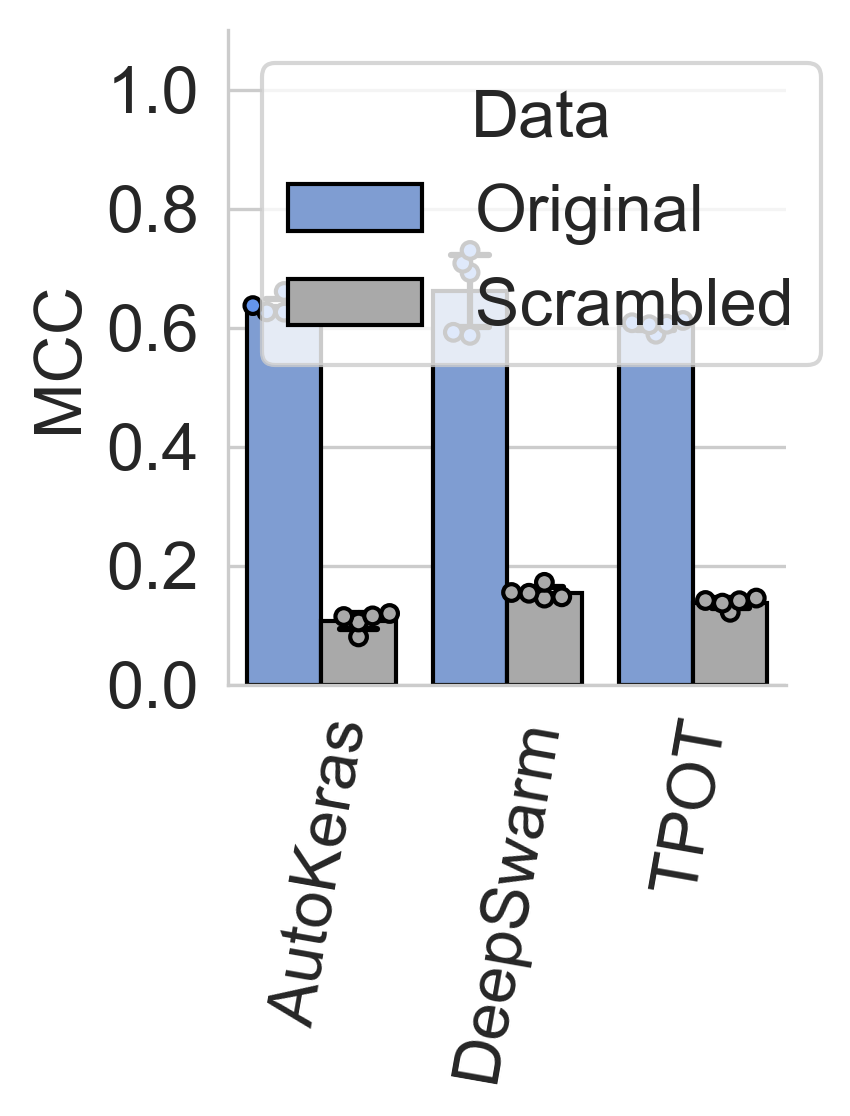

Running statistics now...
AutoKeras
Ttest_indResult(statistic=68.70301007638271, pvalue=2.2426641089709034e-12)
DeepSwarm
Ttest_indResult(statistic=25.485018001930072, pvalue=6.022770818841e-09)
TPOT
Ttest_indResult(statistic=93.60504254745615, pvalue=1.8940751044235584e-13)


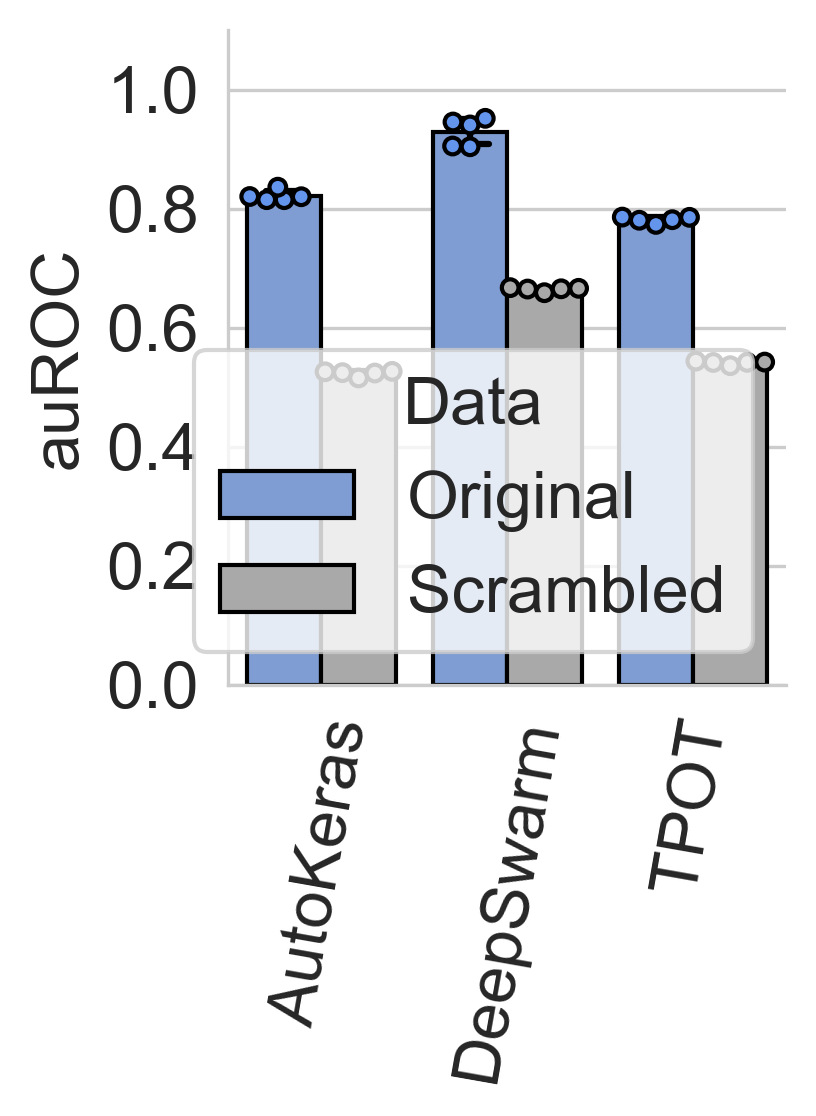

In [112]:
# load in toeholds
data_path = '../exemplars/fig2/'
seq_type = 'toeholds/'
df = calc_mcc(data_path, seq_type, 'all values of MCC Class 0')
plot_barplot(df, '../clean_figs/fig2/toeholds_mcc.svg', 'MCC') 

df = calc_mcc(data_path, seq_type, 'all values of auROC Macro ')
plot_barplot(df, '../clean_figs/fig2/toeholds_auc.svg', 'auROC') 

Running statistics now...
AutoKeras
Ttest_indResult(statistic=11.215941962843194, pvalue=3.5816938119511164e-06)
DeepSwarm
Ttest_indResult(statistic=2.440028160258266, pvalue=0.04056272597281732)
TPOT
Ttest_indResult(statistic=1.563961895065088, pvalue=0.1564555597303802)


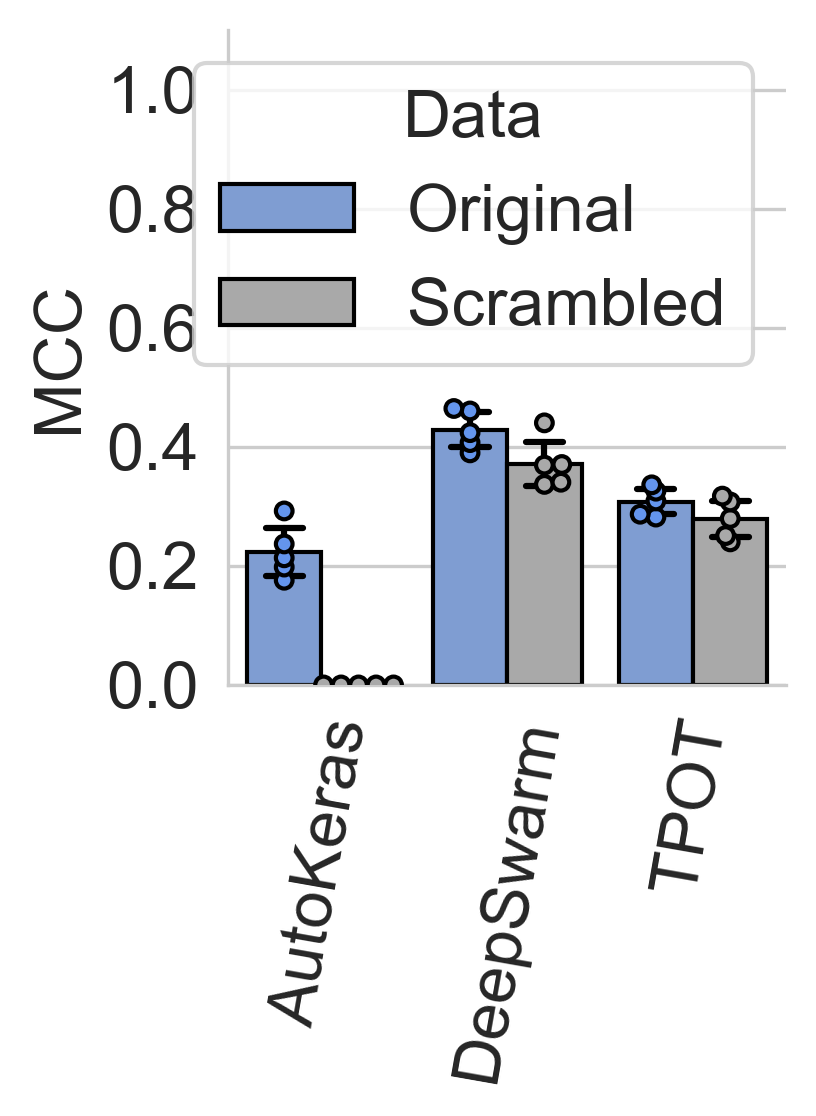

Running statistics now...
AutoKeras
Ttest_indResult(statistic=5.11595448686261, pvalue=0.00091172443550815)
DeepSwarm
Ttest_indResult(statistic=2.6600508120554296, pvalue=0.028803208138716934)
TPOT
Ttest_indResult(statistic=1.3185266171905845, pvalue=0.22382248692287388)


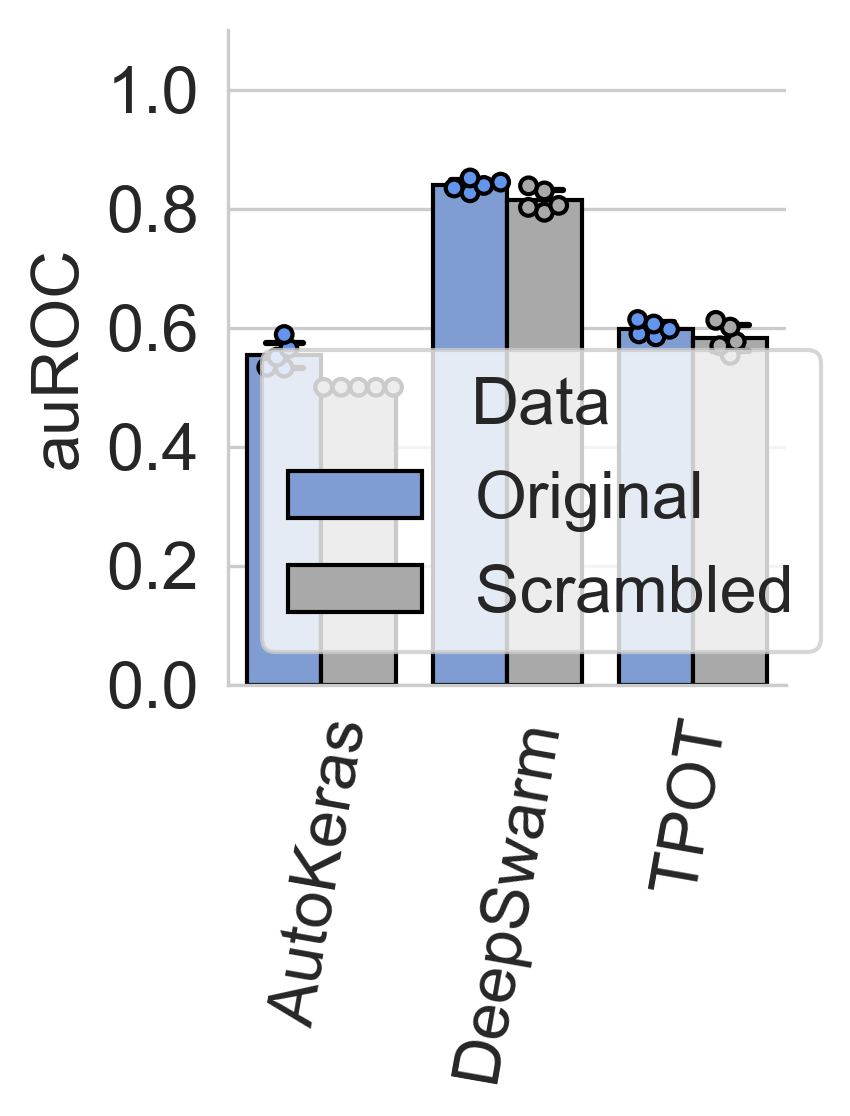

In [113]:
# load in promoters
seq_type = 'promoters/'
df = calc_mcc(data_path, seq_type, 'all values of MCC Class 0')
plot_barplot(df, '../clean_figs/fig2/promoters_mcc.svg', 'MCC') 

df = calc_mcc(data_path, seq_type, 'all values of auROC Macro ')
plot_barplot(df, '../clean_figs/fig2/promoters_auc.svg', 'auROC') 

Running statistics now...
AutoKeras
Ttest_indResult(statistic=0.554543639157634, pvalue=0.5943661897195973)
DeepSwarm
Ttest_indResult(statistic=nan, pvalue=nan)
TPOT
Ttest_indResult(statistic=nan, pvalue=nan)


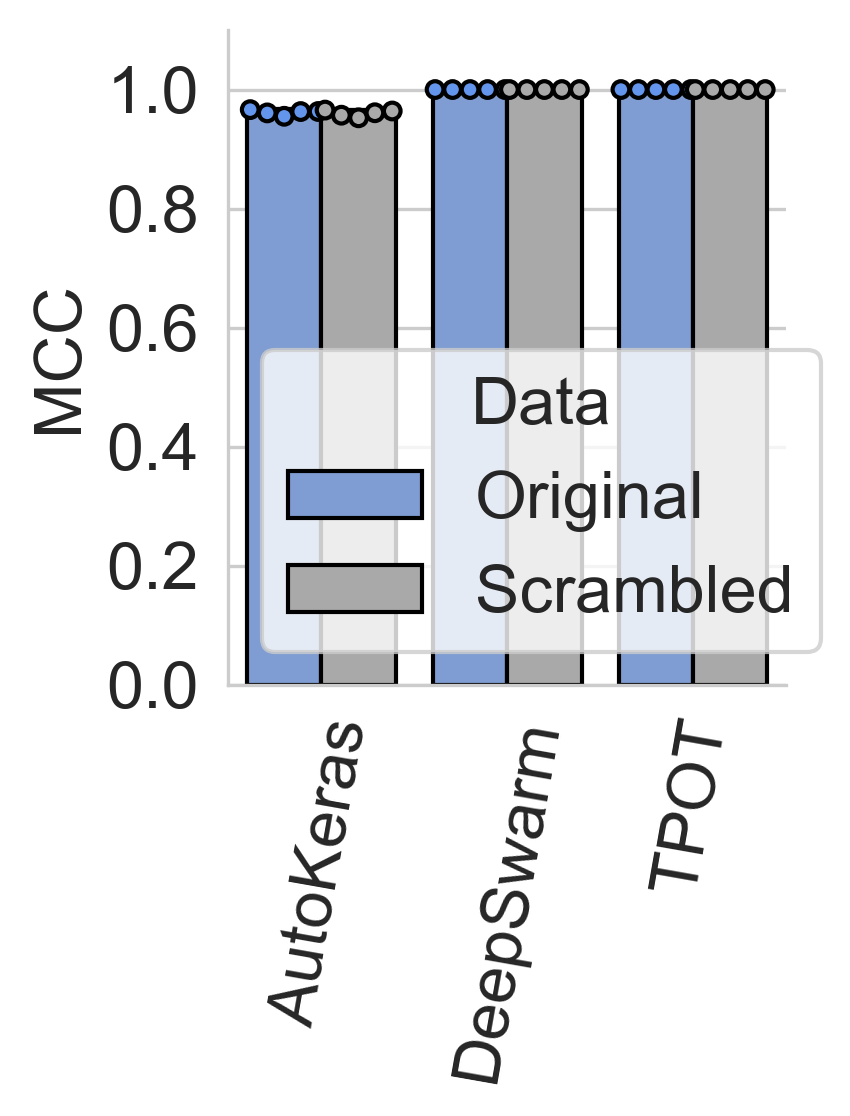

Running statistics now...
AutoKeras
Ttest_indResult(statistic=1.061953064398593, pvalue=0.3192606058905697)
DeepSwarm
Ttest_indResult(statistic=nan, pvalue=nan)
TPOT
Ttest_indResult(statistic=nan, pvalue=nan)


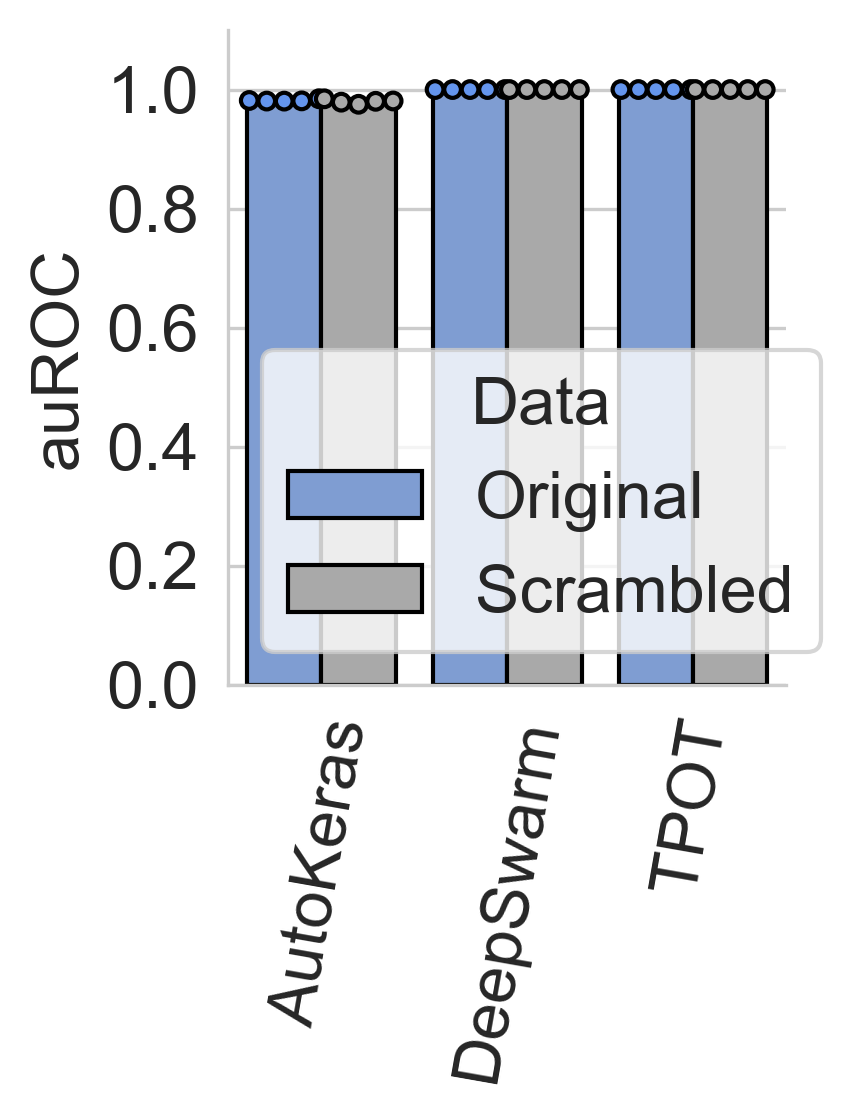

In [114]:
# load in synthetic nas
seq_type = 'synthetic_nucleic_acids/'
df = calc_mcc(data_path, seq_type, 'all values of MCC Class 0')
plot_barplot(df, '../clean_figs/fig2/synthetic_mcc.svg', 'MCC') 

df = calc_mcc(data_path, seq_type, 'all values of auROC Macro ')
plot_barplot(df, '../clean_figs/fig2/synthetic_auc.svg', 'auROC') 

Running statistics now...
AutoKeras
Ttest_indResult(statistic=52.18930116833487, pvalue=2.0136345880845765e-11)
DeepSwarm
Ttest_indResult(statistic=51.954231183977406, pvalue=2.087486167359234e-11)
TPOT
Ttest_indResult(statistic=63.72142854145416, pvalue=4.091255331283274e-12)


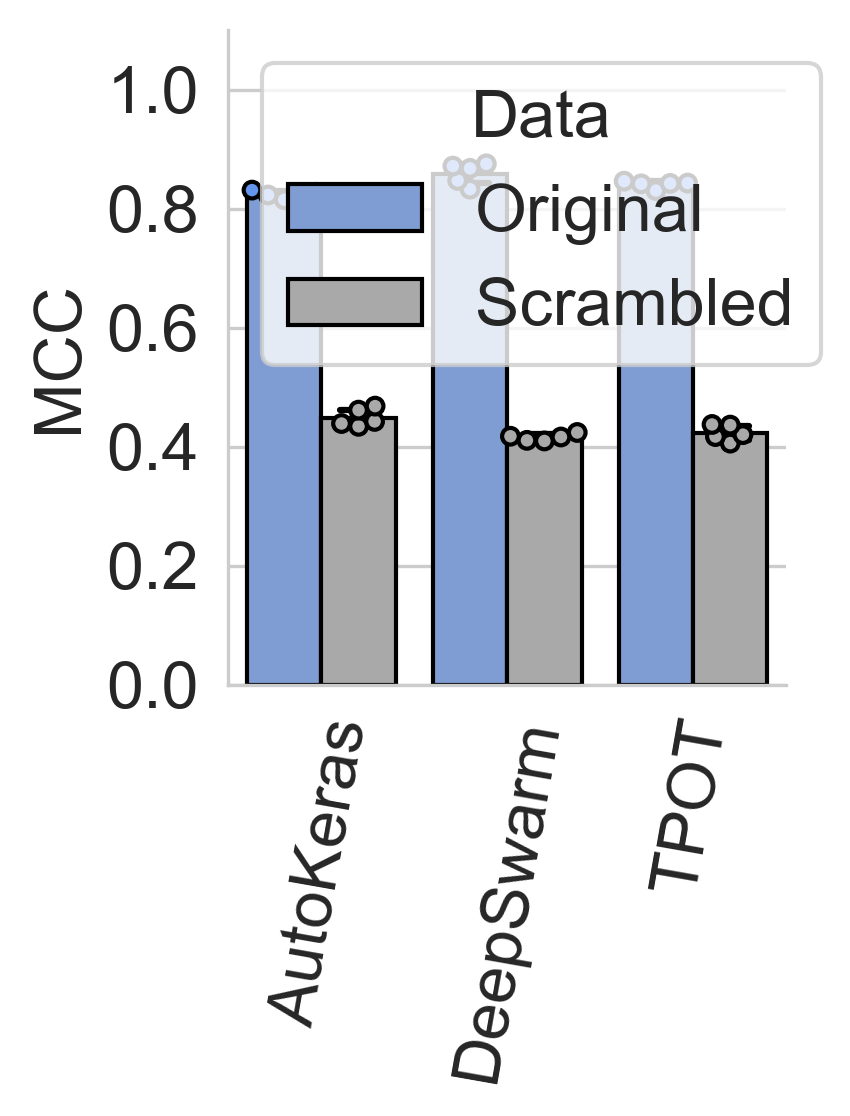

Running statistics now...
AutoKeras
Ttest_indResult(statistic=65.65172340816781, pvalue=3.223663519081216e-12)
DeepSwarm
Ttest_indResult(statistic=77.2911434883452, pvalue=8.75160737862915e-13)
TPOT
Ttest_indResult(statistic=76.34114164532356, pvalue=9.66060043649884e-13)


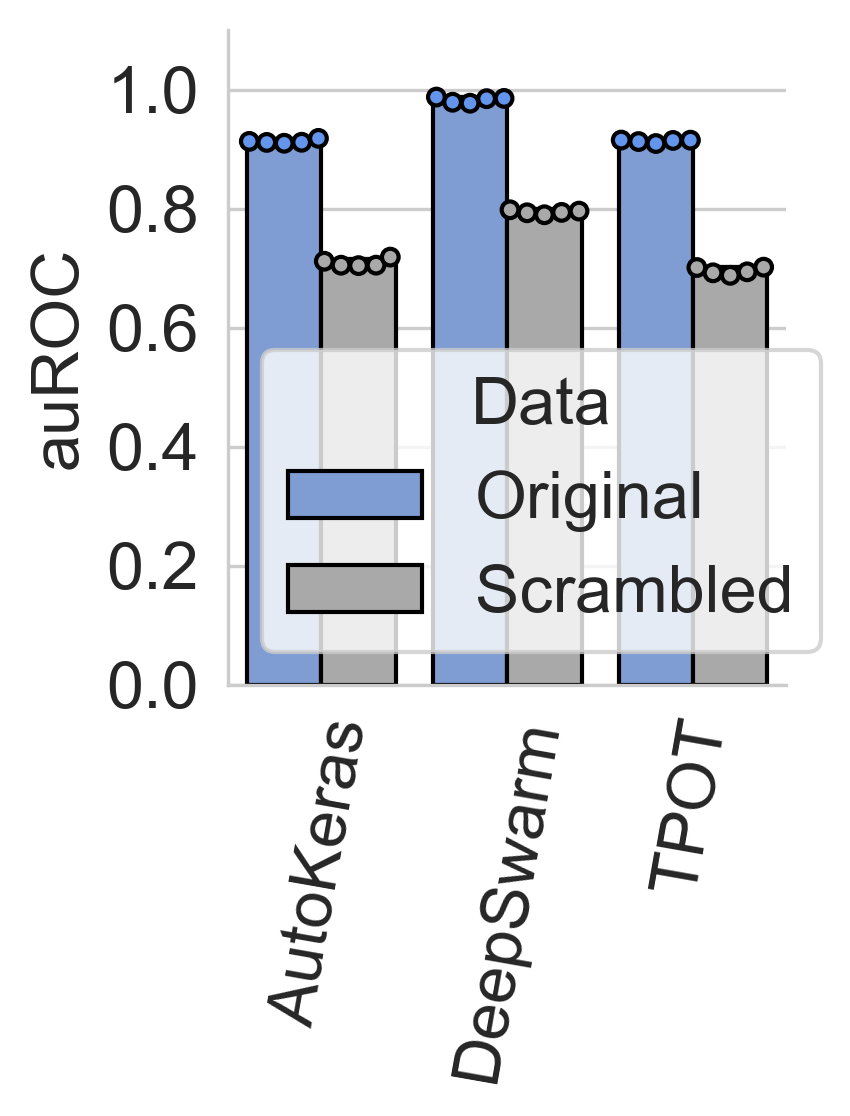

In [115]:
# load in peptides
seq_type = 'rbs/'
df = calc_mcc(data_path, seq_type, 'all values of MCC Class 0')
plot_barplot(df, '../clean_figs/fig2/rbs_mcc.svg', 'MCC') 

df = calc_mcc(data_path, seq_type, 'all values of auROC Macro ')
plot_barplot(df, '../clean_figs/fig2/rbs_auc.svg', 'auROC') 

Running statistics now...
AutoKeras
Ttest_indResult(statistic=18.10082950867665, pvalue=8.910583372576252e-08)
DeepSwarm
Ttest_indResult(statistic=14.475402162581444, pvalue=5.076611536741039e-07)
TPOT
Ttest_indResult(statistic=93.02613606533139, pvalue=1.9903685009625113e-13)


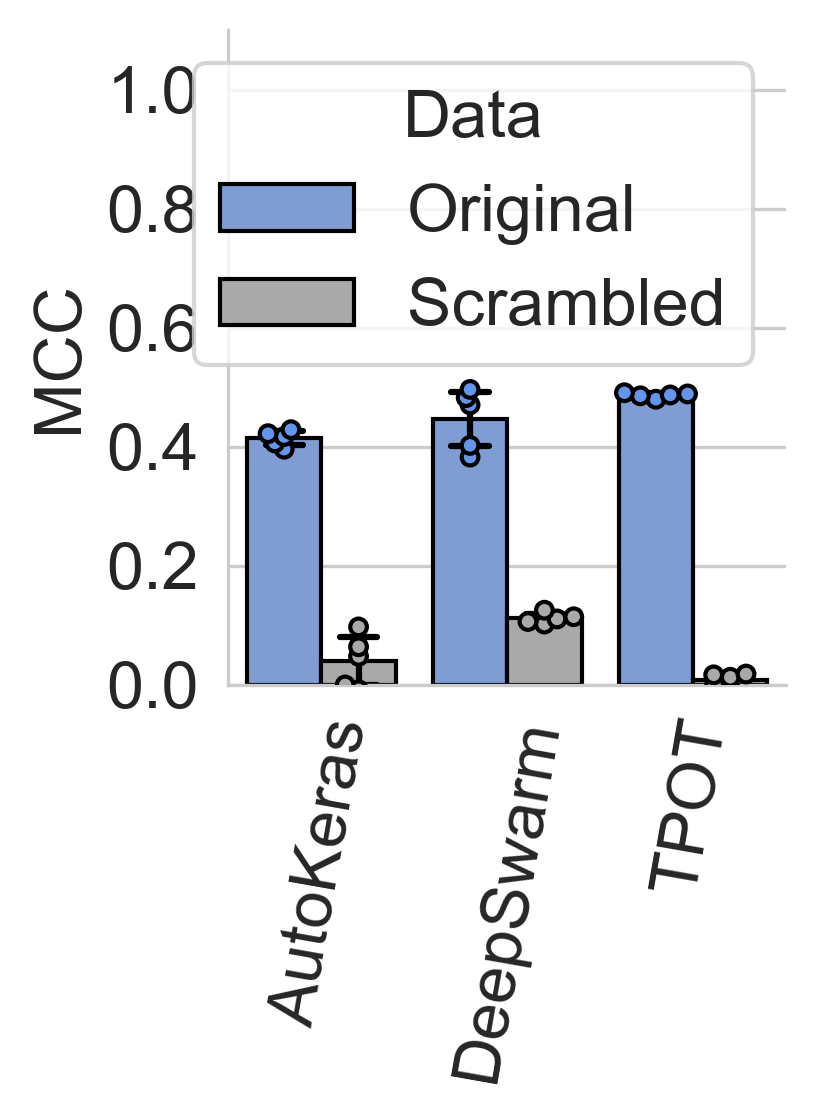

Running statistics now...
AutoKeras
Ttest_indResult(statistic=37.23508550825231, pvalue=2.968952934350114e-10)
DeepSwarm
Ttest_indResult(statistic=10.612537309611904, pvalue=5.436434290691939e-06)
TPOT
Ttest_indResult(statistic=255.74670177414552, pvalue=6.117112551870657e-17)


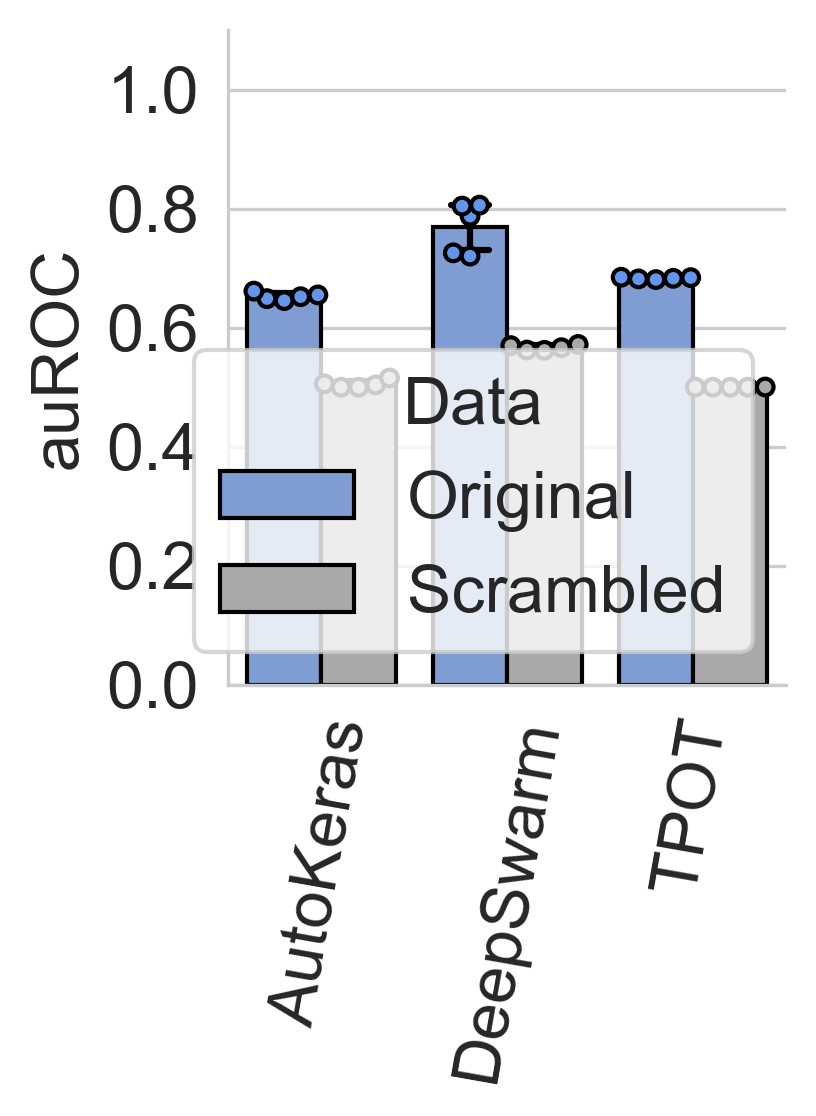

In [116]:
# load in peptides
seq_type = 'peptides/'
df = calc_mcc(data_path, seq_type, 'all values of MCC Class 0')
plot_barplot(df, '../clean_figs/fig2/peptides_mcc.svg', 'MCC') 

df = calc_mcc(data_path, seq_type, 'all values of auROC Macro ')
plot_barplot(df, '../clean_figs/fig2/peptides_auc.svg', 'auROC') 

Running statistics now...
AutoKeras
Ttest_indResult(statistic=nan, pvalue=nan)
DeepSwarm
Ttest_indResult(statistic=1.782383712496751, pvalue=0.11254039453005711)
TPOT
Ttest_indResult(statistic=-1.1801502192048585, pvalue=0.2718395461445731)


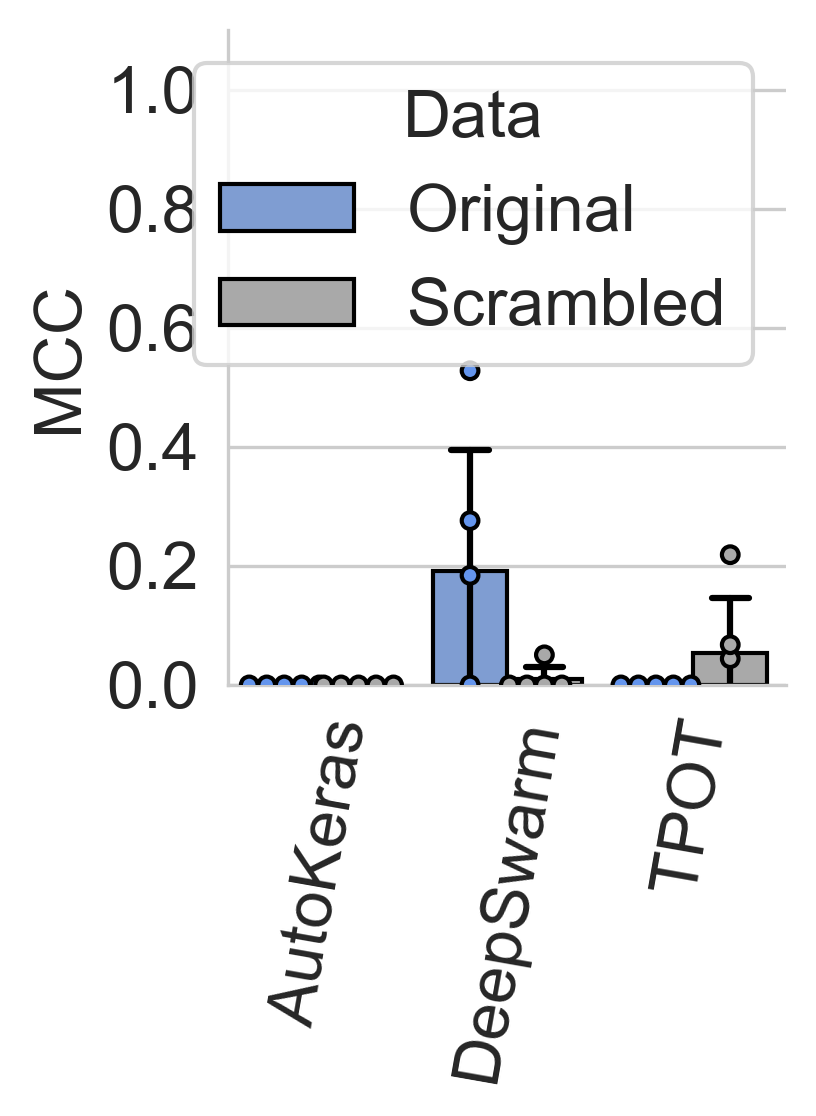

Running statistics now...
AutoKeras
Ttest_indResult(statistic=nan, pvalue=nan)
DeepSwarm
Ttest_indResult(statistic=0.38880794612397296, pvalue=0.707561846925914)
TPOT
Ttest_indResult(statistic=-1.7742144709889944, pvalue=0.11395160520827004)


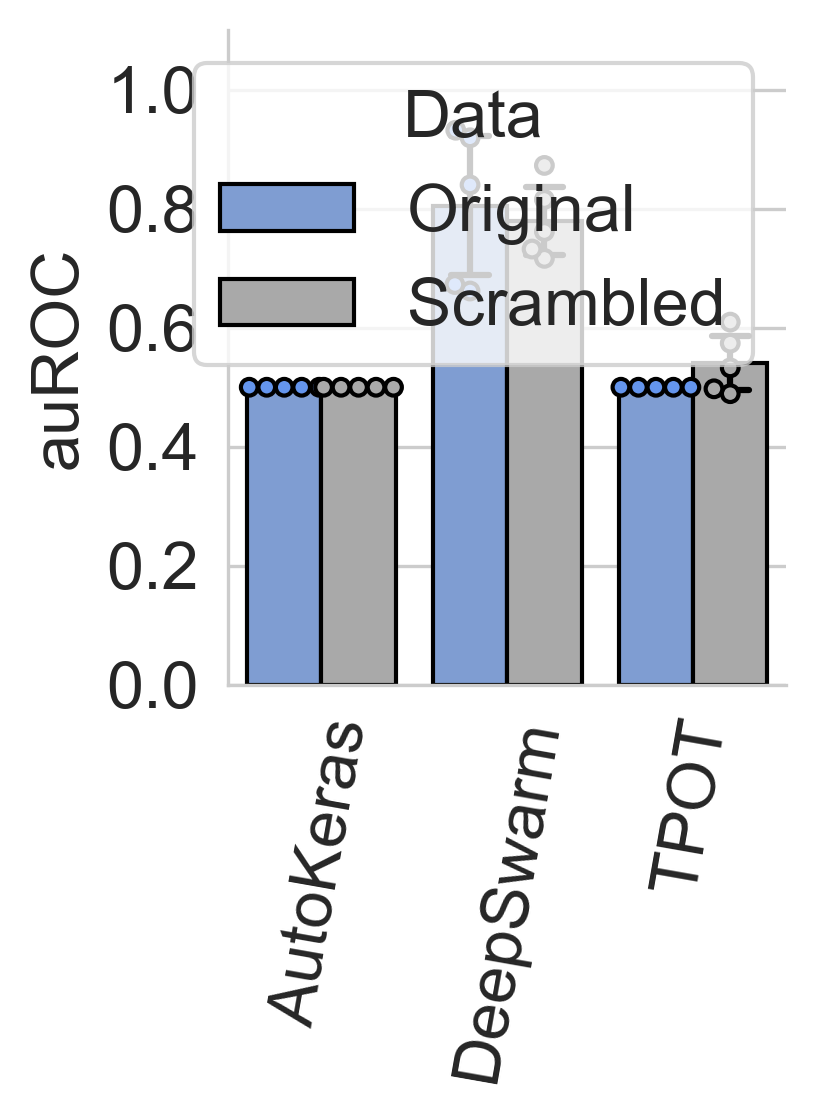

In [117]:
# load in glycans
seq_type = 'glycans_full/'
df = calc_mcc(data_path, seq_type, 'all values of MCC Class 0')
plot_barplot(df, '../clean_figs/fig2/glycans_mcc.svg', 'MCC') 

df = calc_mcc(data_path, seq_type, 'all values of auROC Macro ')
plot_barplot(df, '../clean_figs/fig2/glycans_auc.svg', 'auROC') 

# Plot F : Robustness Test

In [118]:
def calc_robustness(folder, seq, val_name, maxlen):
    folds = ['outputs/autokeras/binary_classification/', 'outputs/deepswarm/binary_classification/', 'outputs/tpot/binary_classification/']
    columns = ['$\it{Model}$', 'datasize', 'fold', 'value', '$\it{Data}$']
    mcc = pd.DataFrame(columns = columns)
    
    file_name = 'results.txt'
    for fold in folds:
        name = fold.split('outputs/')[1].split('/binary_classification')[0] 
        name = name.replace('deepswarm', 'DeepSwarm')
        name = name.replace('autokeras', 'AutoKeras')
        name = name.replace('tpot', 'TPOT')
        
        # initialize it with the full dataset mccc
        for filename in glob.glob(folder + seq + fold + '*' +  file_name):
            scrambled = 'Original'
            size = maxlen
            df = pd.read_csv(filename, sep = '\t', header = None)
            vals = df.values
            for i in range(len(vals)):
                val = vals[i]
                if val_name in val[0]:
                    new = val[0].split(": ")[1]
                    new = new.strip("[")
                    new = new.strip("]")

                    new = [s for s in new.split(' ')]
                    new = [s for s in new if s != '']
                    new = [0 if s == '0.' else s for s in new]
                    new = [float(s) for s in new]
                    index = 0
                    for n in new:
                        entire_new_row = [name, int(size), int(index), n, scrambled]
                        entire_new_row = pd.DataFrame(entire_new_row).transpose()
                        entire_new_row.columns = columns  
                        mcc = pd.concat([mcc, entire_new_row])
                        index = index + 1
        
        # add on it the scrambled dataset mccc
        file_name = 'all_scrambled_control_results.txt'
        for filename in glob.glob(folder + seq + fold + 'scrambled/' +  file_name):
            scrambled = 'Scrambled'
            size = maxlen
            df = pd.read_csv(filename, sep = '\t', header = None)
            vals = df.values
            for i in range(len(vals)):
                val = vals[i]
                if val_name in val[0]:
                    new = val[0].split(": ")[1]
                    new = new.strip("[")
                    new = new.strip("]")

                    new = [s for s in new.split(' ')]
                    new = [s for s in new if s != '']
                    new = [0 if s == '0.' else s for s in new]
                    new = [float(s) for s in new]
                    index = 0
                    for n in new:
                        entire_new_row = [name, int(size), int(index), n, scrambled]
                        entire_new_row = pd.DataFrame(entire_new_row).transpose()
                        entire_new_row.columns = columns  
                        mcc = pd.concat([mcc, entire_new_row])
                        index = index + 1
        
        file_name = 'results.txt'
        # now do the rest!
        for filename in glob.glob(folder + seq + fold + 'robustness/*' +  file_name):
            if 'scrambled' in filename:
                scrambled = 'Scrambled'
            else:
                scrambled = 'Original'
            size = filename.split("robustness/")[1].split("_")[0]
            df = pd.read_csv(filename, sep = '\t', header = None)
            vals = df.values
            for i in range(len(vals)):
                val = vals[i]
                if val_name in val[0]:
                    new = val[0].split(": ")[1]
                    new = new.strip("[")
                    new = new.strip("]")

                    new = [s for s in new.split(' ')]
                    new = [s for s in new if s != '']
                    new = [0 if s == '0.' else s for s in new]
                    new = [float(s) for s in new]
                    index = 0
                    for n in new:
                        entire_new_row = [name, int(size), int(index), n, scrambled]
                        entire_new_row = pd.DataFrame(entire_new_row).transpose()
                        entire_new_row.columns = columns  
                        mcc = pd.concat([mcc, entire_new_row])
                        index = index + 1
    return(mcc)

def plot_lineplot(mcc, savepath, yaxis):
    #mcc = reshape(mcc)  
    mcc.datasize = df.datasize.astype(float)
    mcc.value = df.value.astype(float)
    plt.figure(figsize=(6,4), dpi=300)
    my_pal = {"AutoKeras": "cornflowerblue", "DeepSwarm": "sandybrown", "TPOT": "grey"}
    ax = sns.lineplot(x = 'datasize', y = 'value', hue = '$\it{Model}$', style = '$\it{Data}$', data=mcc,  alpha = 1, linewidth = 2,  ci = 'sd', palette = my_pal)
    sns.scatterplot(x = 'datasize', y = 'value', hue = '$\it{Model}$', data=mcc, edgecolor='black', alpha = 1, linewidth = 0.4, s = 10, palette = my_pal)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[:7], labels[:7], bbox_to_anchor=(1.01, 1), borderaxespad=0)
    plt.xlabel('Dataset Size')
    plt.xticks(rotation = 60)
    plt.ylabel(yaxis)
    ax.set_xscale('log')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.tight_layout()
    plt.savefig(savepath)
    plt.show()

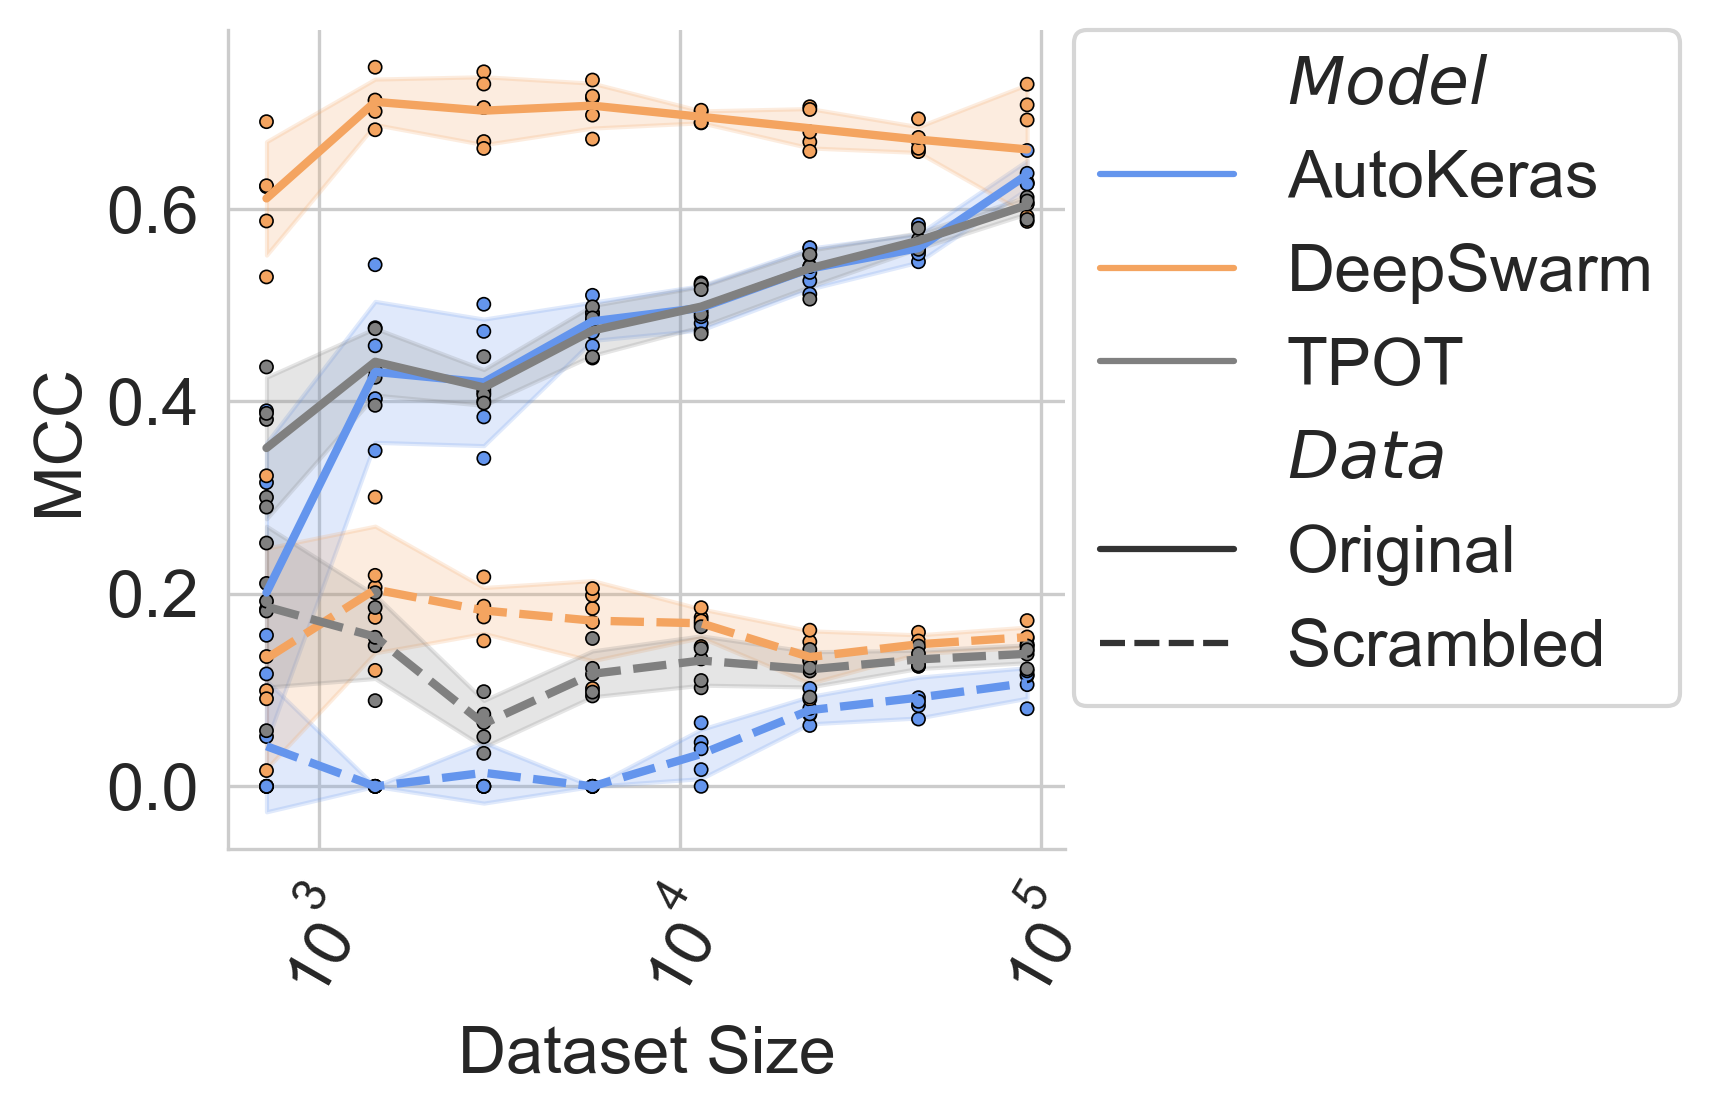

In [119]:
data_path = '../exemplars/fig2/'
seq_type = 'toeholds/'
df = calc_robustness(data_path, seq_type, 'all values of MCC Class 0', 91534)
plot_lineplot(df, '../clean_figs/fig2/toeholds_robustness.svg', 'MCC')

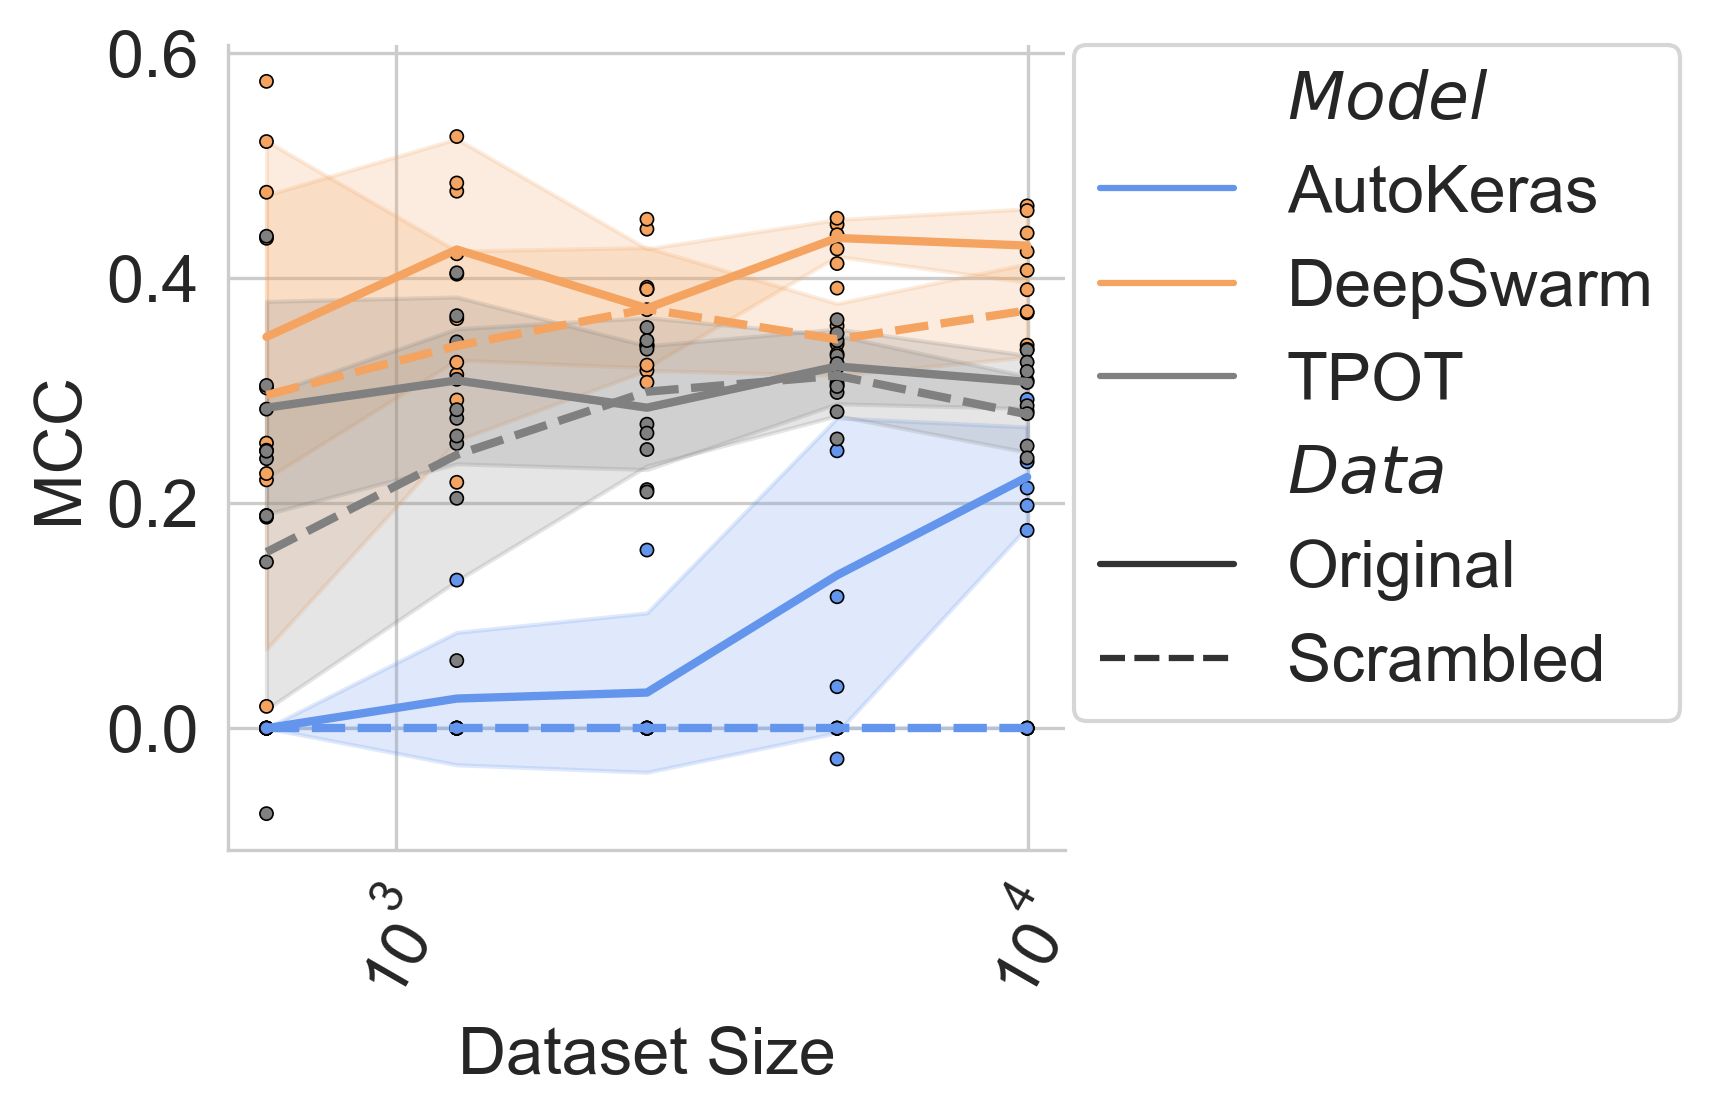

In [120]:
data_path = '../exemplars/fig2/'
seq_type = 'promoters/'
df = calc_robustness(data_path, seq_type, 'all values of MCC Class 0', 9982)
plot_lineplot(df, '../clean_figs/fig2/promoters_robustness.svg', 'MCC')

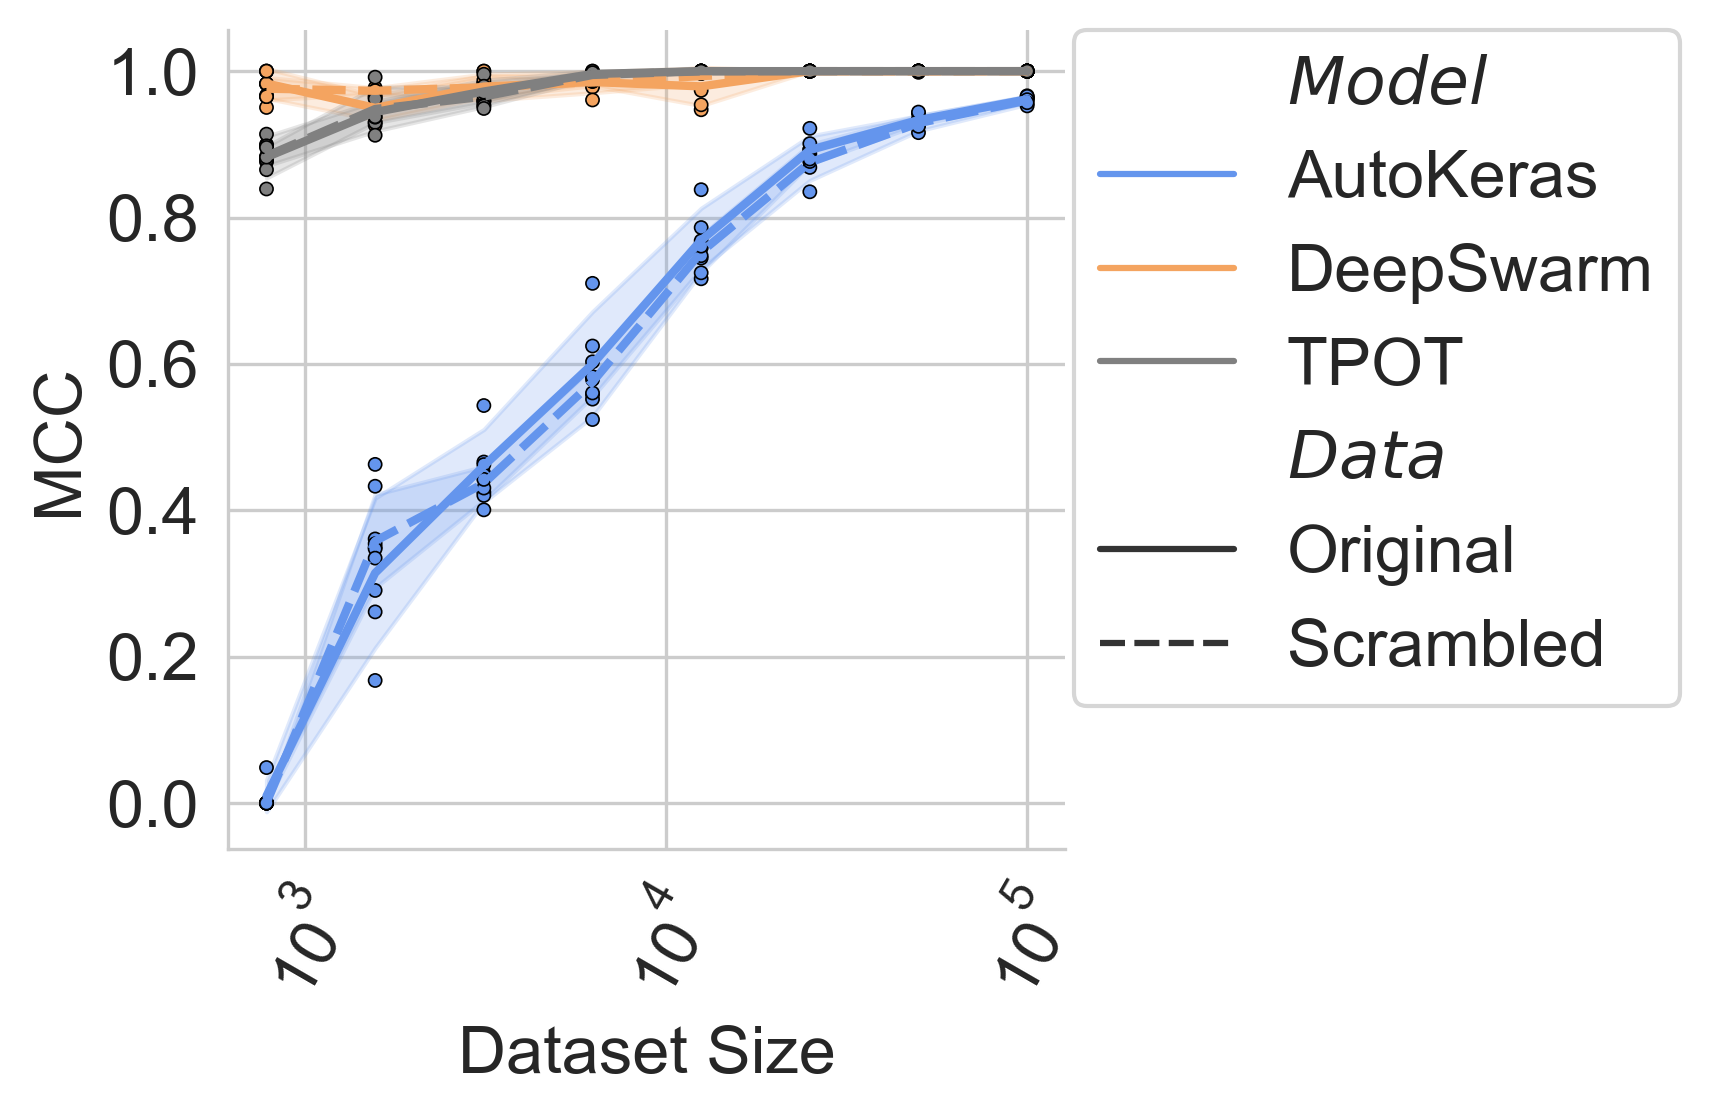

In [121]:
data_path = '../exemplars/fig2/'
seq_type = 'synthetic_nucleic_acids/'
df = calc_robustness(data_path, seq_type, 'all values of MCC Class 0', 100000)
plot_lineplot(df, '../clean_figs/fig2/synthetic_nucleic_acids_robustness.svg', 'MCC')

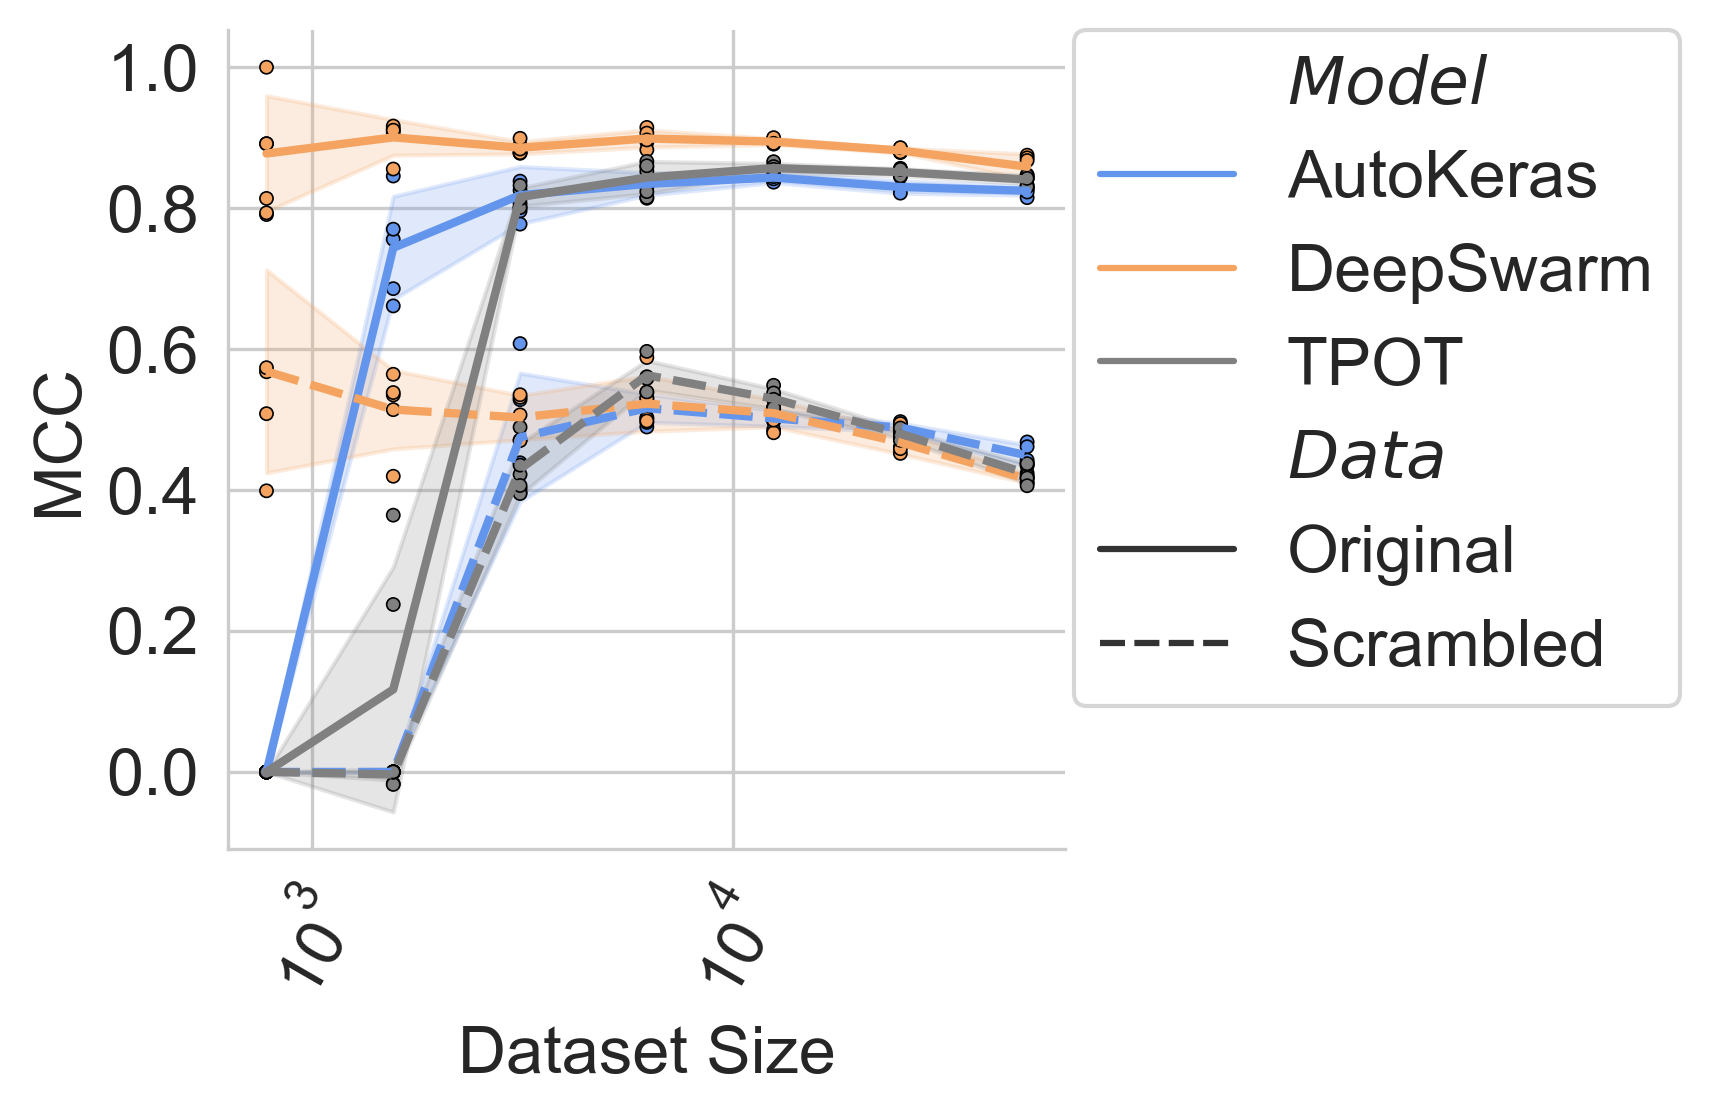

In [122]:
data_path = '../exemplars/fig2/'
seq_type = 'rbs/'
df = calc_robustness(data_path, seq_type, 'all values of MCC Class 0', 50000)
plot_lineplot(df, '../clean_figs/fig2/rbs_robustness.svg', 'MCC')

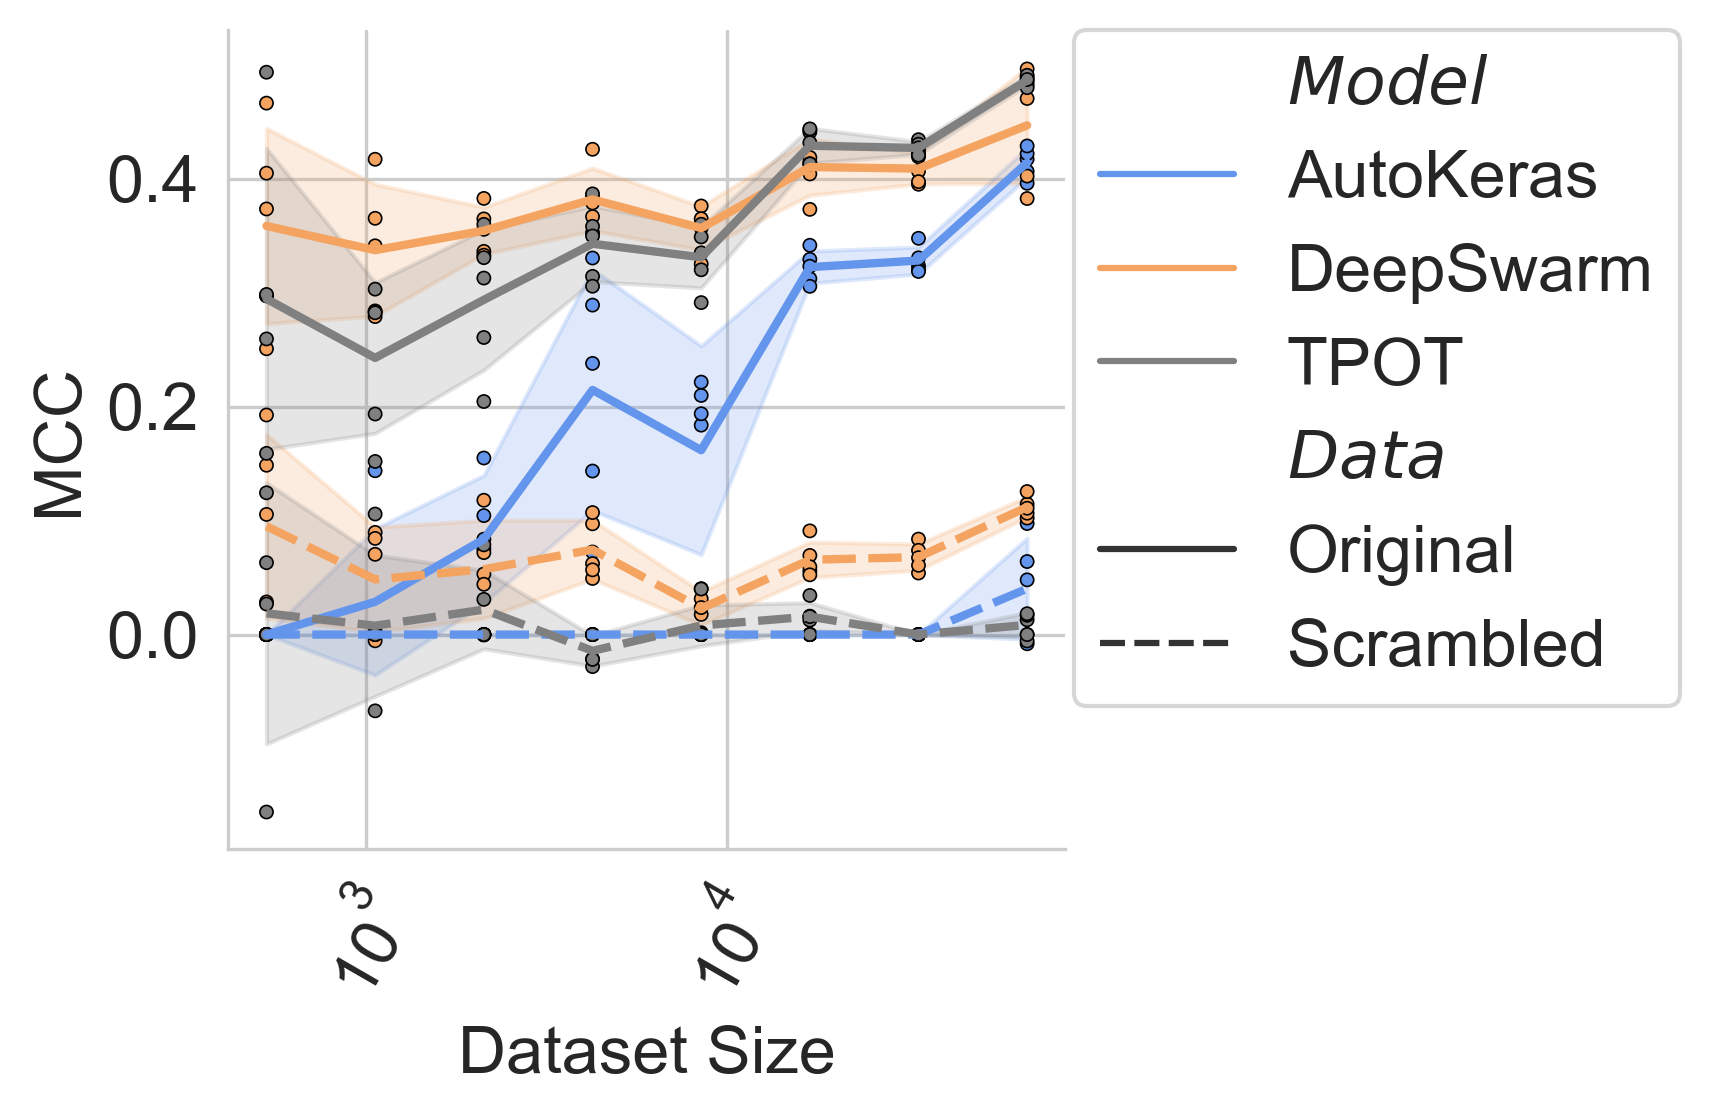

In [123]:
data_path = '../exemplars/fig2/'
seq_type = 'peptides/'
df = calc_robustness(data_path, seq_type, 'all values of MCC Class 0', 67769)
plot_lineplot(df, '../clean_figs/fig2/peptides_robustness.svg', 'MCC')

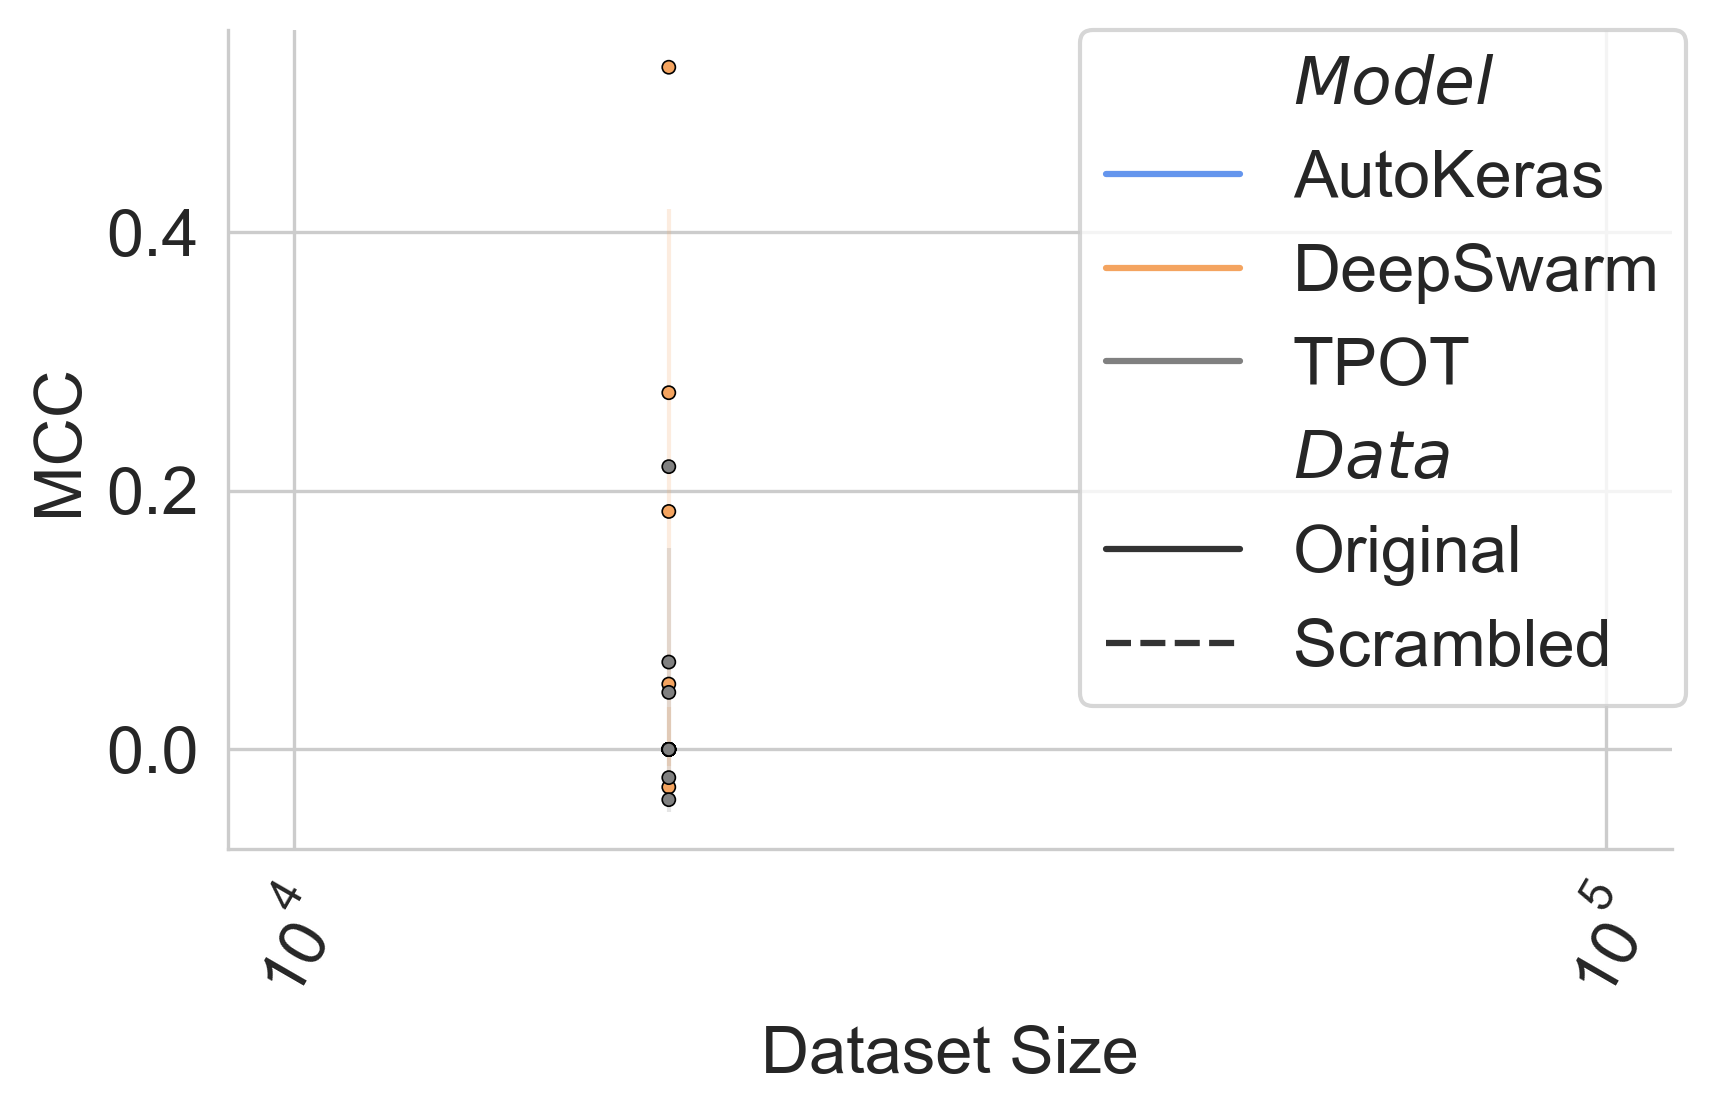

In [124]:
data_path = '../exemplars/fig2/'
seq_type = 'glycans_full/'
df = calc_robustness(data_path, seq_type, 'all values of MCC Class 0', 19299)
plot_lineplot(df, '../clean_figs/fig2/glycans_robustness.svg', 'MCC')

# Plot G: Time To Compute

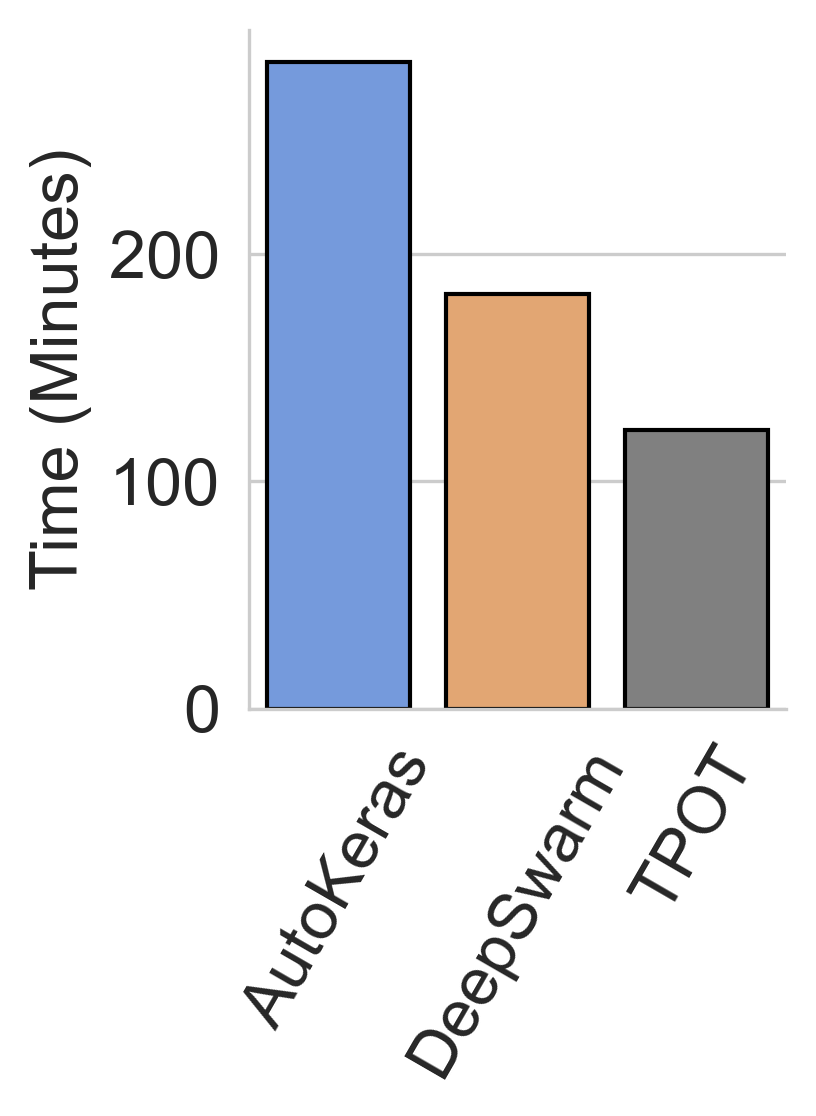

In [125]:
def calc_time(folder, seq):
    folds = ['outputs/autokeras/binary_classification/', 'outputs/deepswarm/binary_classification/', 'outputs/tpot/binary_classification/']
    time = pd.DataFrame()
    file_name = 'runtime_statistics.txt'
    for fold in folds:
        name = fold.split('outputs/')[1].split('/binary_classification')[0]
        name = name.replace('deepswarm', 'DeepSwarm')
        name = name.replace('autokeras', 'AutoKeras')
        name = name.replace('tpot', 'TPOT')
        df = pd.read_csv(folder + seq + fold + file_name, sep = '\t', header = None)
        vals = df.values
        for i in range(len(vals)):
            val = vals[i]
            new = val[0].split("Elapsed time : ")[1].split(" minutes")[0]
            new = float(new)
            time[name] = [new]
    return(time)

def plot_time(mcc, savepath, yaxis):
    plt.figure(figsize=(3,4), dpi=300)
    my_pal = {"AutoKeras": "cornflowerblue", "DeepSwarm": "sandybrown", "TPOT": "grey"}
    ax = sns.barplot(data=mcc, edgecolor='black', alpha = 1, linewidth = 1, palette = my_pal)
    plt.xlabel('')
    plt.xticks(rotation = 60)
    plt.ylabel(yaxis)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.tight_layout()
    plt.savefig(savepath)
    plt.show()

data_path = '../exemplars/fig2/'
seq_type = 'toeholds/'
df = calc_time(data_path, seq_type) 
plot_time(df, '../clean_figs/fig2/toeholds_time.svg', 'Time (Minutes)')

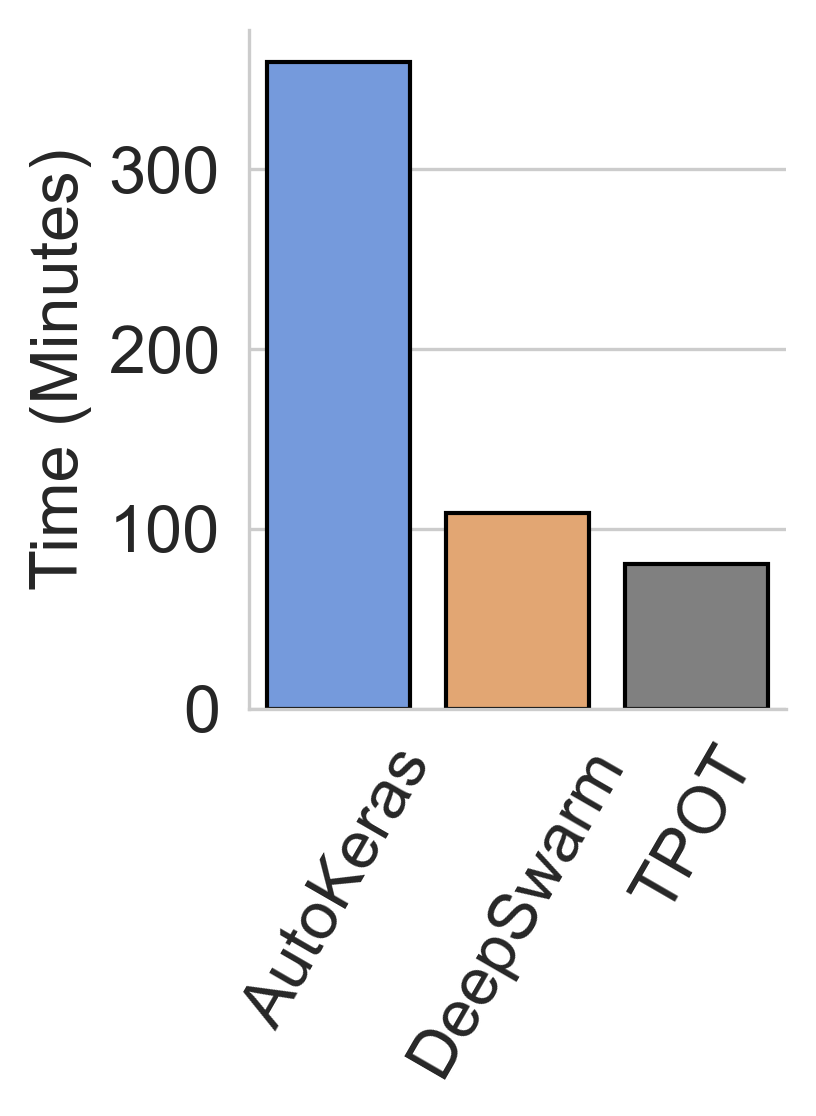

In [126]:
data_path = '../exemplars/fig2/'
seq_type = 'peptides/'
df = calc_time(data_path, seq_type) 
plot_time(df, '../clean_figs/fig2/peptides_time.svg', 'Time (Minutes)')

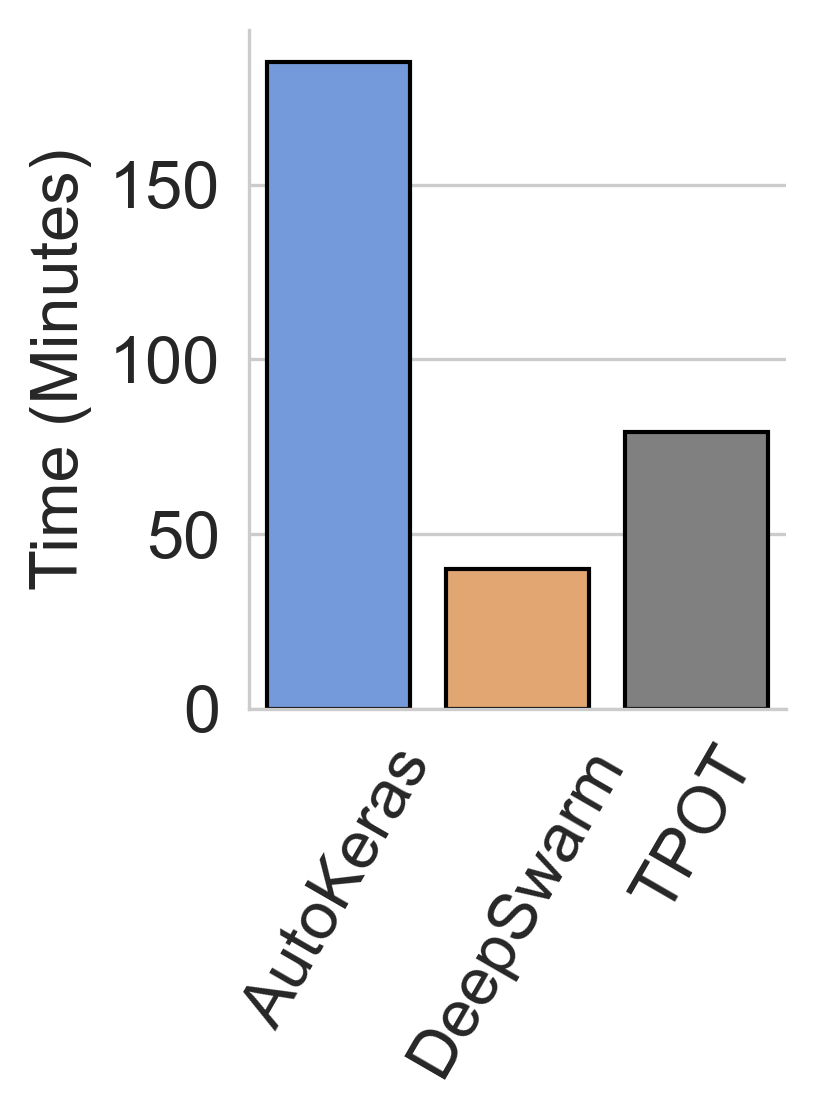

In [127]:
data_path = '../exemplars/fig2/'
seq_type = 'rbs/'
df = calc_time(data_path, seq_type) 
plot_time(df, '../clean_figs/fig2/rbs_time.svg', 'Time (Minutes)')

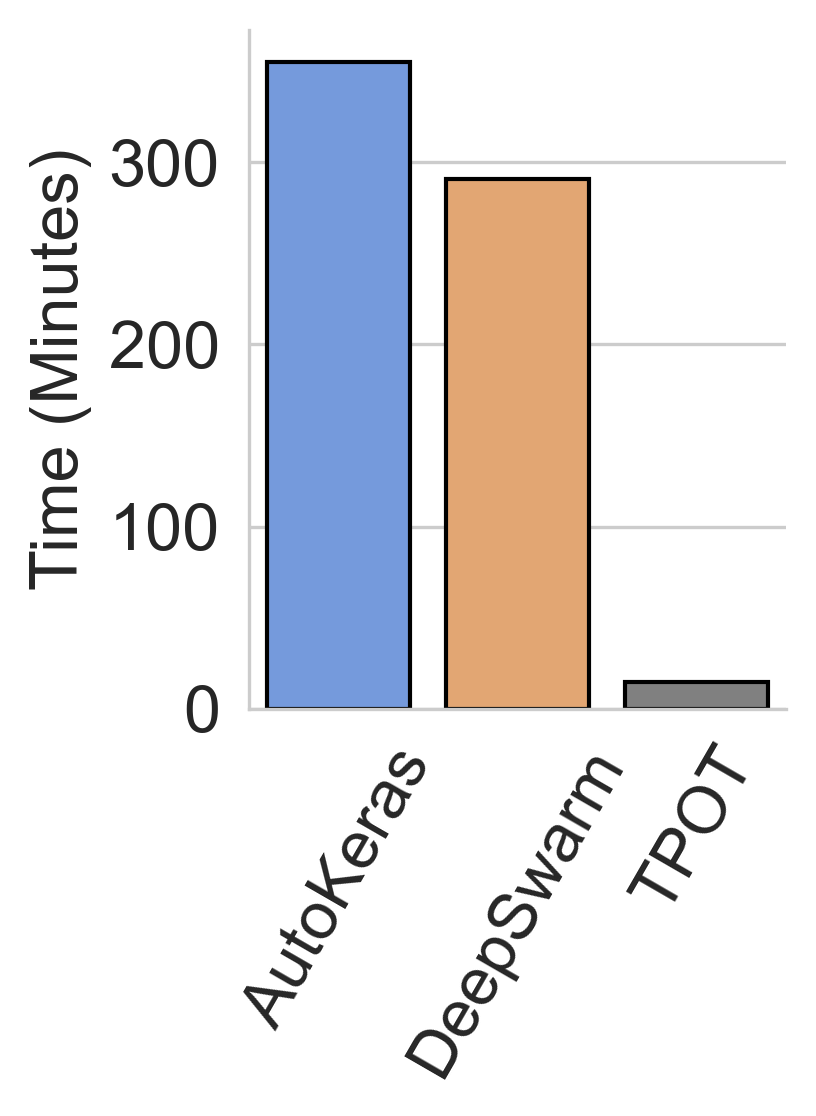

In [128]:
data_path = '../exemplars/fig2/'
seq_type = 'glycans_full/'
df = calc_time(data_path, seq_type) 
plot_time(df, '../clean_figs/fig2/glycans_time.svg', 'Time (Minutes)')

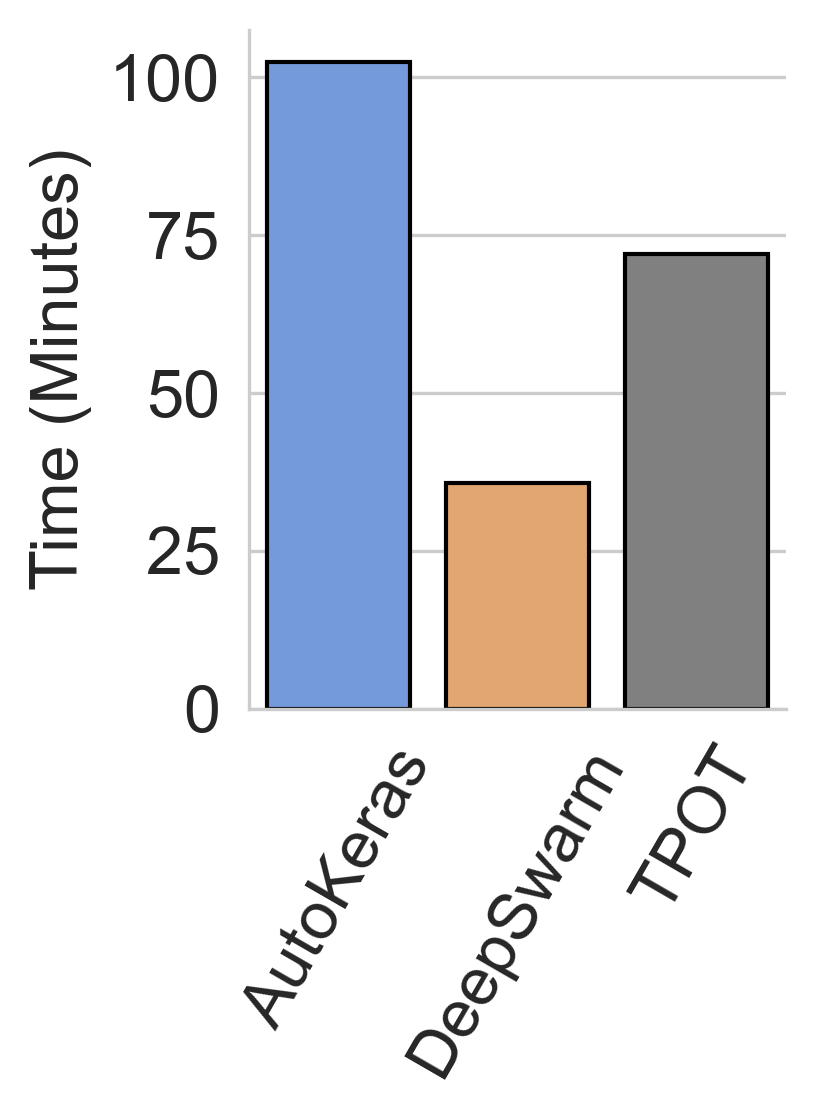

In [129]:
data_path = '../exemplars/fig2/'
seq_type = 'promoters/'
df = calc_time(data_path, seq_type) 
plot_time(df, '../clean_figs/fig2/promoters_time.svg', 'Time (Minutes)')

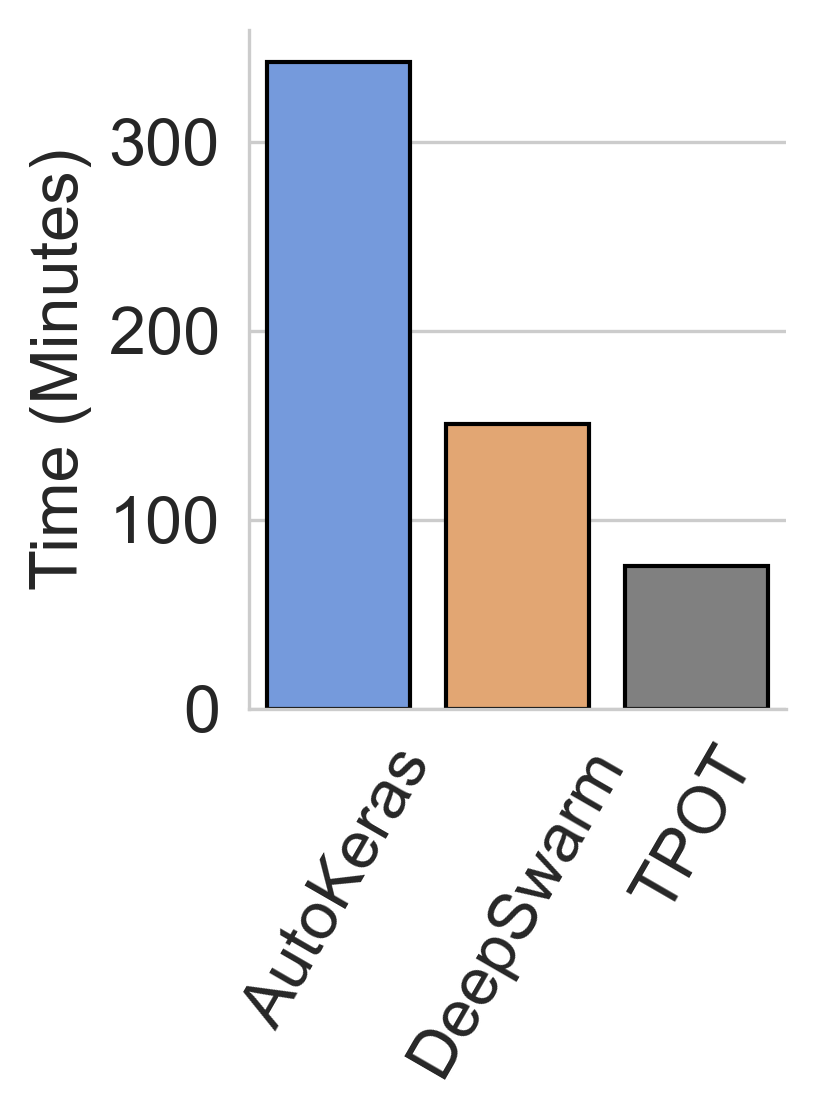

In [130]:
data_path = '../exemplars/fig2/'
seq_type = 'synthetic_nucleic_acids/'
df = calc_time(data_path, seq_type) 
plot_time(df, '../clean_figs/fig2/synthetic_nucleic_acids_time.svg', 'Time (Minutes)')

# Complementation Figures

Running statistics now...
AutoKeras
Ttest_indResult(statistic=84.17037866845814, pvalue=4.427711267797087e-13)
DeepSwarm
Ttest_indResult(statistic=27.0592849430944, pvalue=3.747109509197775e-09)
TPOT
Ttest_indResult(statistic=34.9012265710537, pvalue=4.968866048922187e-10)


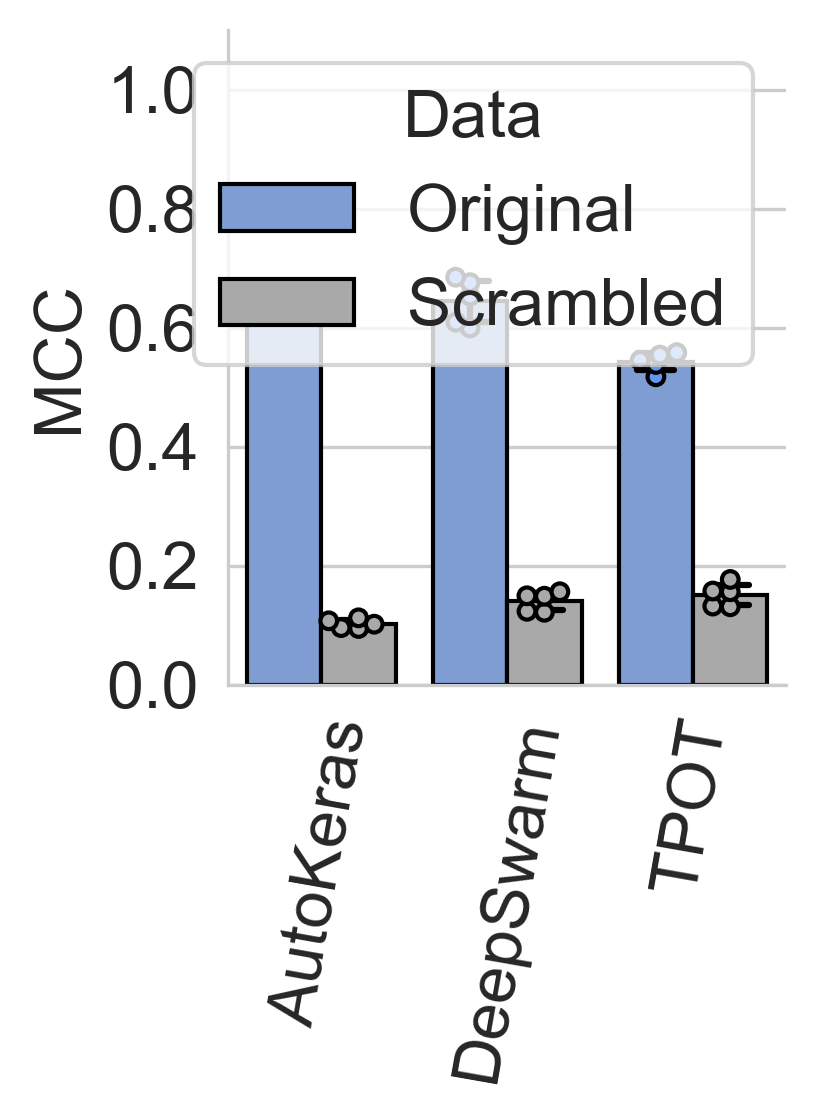

In [131]:
# load in toeholds
data_path = '../exemplars/fig2/'
seq_type = 'toeholds_COMP_aug/'
df = calc_mcc(data_path, seq_type, 'all values of MCC Class 0')
plot_barplot(df, '../clean_figs/fig2/COMP_aug_toeholds_mcc.svg', 'MCC') 

In [132]:
def reshape_aug_type(df):
    new = pd.DataFrame()
    new['model_type'] = []
    new
    index = 0
    for name, col in df.iteritems():
        if 'scr' in name or 'augtype' in name:
            continue
        new_pd = pd.DataFrame(col)
        new_pd.columns = ['values']
        new_pd['scr'] = list(df['scr'])
        new_pd['model_type'] = [name] * len(new_pd)
        new_pd['augtype'] = list(df['augtype'])
        new = pd.concat([new, new_pd])
        index = index + 1
    new.columns = ['Model', 'MCC', 'Data', 'Augmentation']
    return(new)

def plot_barplot_aug_type(mcc, savepath, yaxis):
    mcc = reshape_aug_type(mcc)  
    plt.figure(figsize=(3,4), dpi=200)
    my_pal = {"Original": "cornflowerblue", "Scrambled": "darkgrey"}
    ax = sns.barplot(x = 'Augmentation', y = 'MCC', hue = 'Data', data=mcc, edgecolor='black', alpha = 1, linewidth = 1, palette = my_pal, ci = 'sd', errcolor = 'black', errwidth = 1.5, capsize = 0.2, saturation = 0.6)
    sns.swarmplot(x = 'Augmentation', y = 'MCC', hue = 'Data', data=mcc, dodge = True, edgecolor='black', alpha = 1, linewidth = 1, s = 4, palette = my_pal)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[2:4], labels[2:4], title='Data')
    # Define some hatches
    #hatches = ['//', '']

    # Loop over the bars
    #for i,thisbar in enumerate(ax.patches):
    #    # Set a different hatch for each bar
    #    thisbar.set_hatch(hatches[i % len(hatches)])
    plt.xlabel('')
    plt.xticks(rotation = 80)
    plt.ylabel(yaxis)
    plt.ylim([0, 1.1])
    plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.tight_layout()
    plt.savefig(savepath)
    plt.show()

Running statistics now...
AutoKeras
Ttest_indResult(statistic=54.50919971045782, pvalue=1.4231660455590026e-11)
DeepSwarm
Ttest_indResult(statistic=16.638118689765427, pvalue=1.7212022873720275e-07)
TPOT
Ttest_indResult(statistic=81.28786074695515, pvalue=5.849526373565125e-13)
Running statistics now...
AutoKeras
Ttest_indResult(statistic=84.17037866845814, pvalue=4.427711267797087e-13)
DeepSwarm
Ttest_indResult(statistic=27.0592849430944, pvalue=3.747109509197775e-09)
TPOT
Ttest_indResult(statistic=34.9012265710537, pvalue=4.968866048922187e-10)
Running statistics now...
AutoKeras
Ttest_indResult(statistic=96.20710961810211, pvalue=1.5212826975646685e-13)
DeepSwarm
Ttest_indResult(statistic=59.74529529345392, pvalue=6.8436555002803764e-12)
TPOT
Ttest_indResult(statistic=103.49869042626865, pvalue=8.483439730632932e-14)
Running statistics now...
AutoKeras
Ttest_indResult(statistic=118.7033496831031, pvalue=2.8354814217831656e-14)
DeepSwarm
Ttest_indResult(statistic=25.72353494027945, p

/anaconda2/envs/automl_py37/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 13.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/anaconda2/envs/automl_py37/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 40.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/anaconda2/envs/automl_py37/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 6.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/anaconda2/envs/automl_py37/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 33.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/anaconda2/envs/automl_py37/lib/python3.7/site-packag

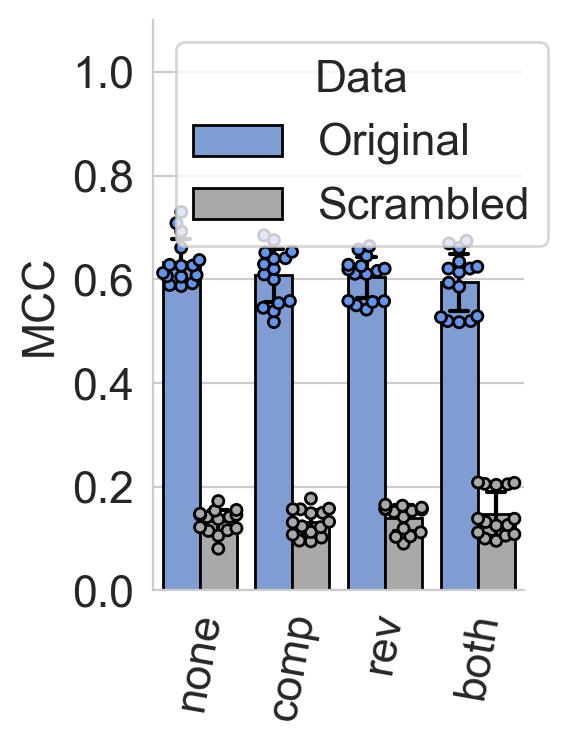

In [133]:
# load in toeholds
data_path = '../exemplars/fig2/'

for seq_type in ['toeholds/', 'toeholds_COMP_aug/', 'toeholds_REVCOMP_aug/', 'toeholds_BOTHCOMP_aug/']:
    df = calc_mcc(data_path, seq_type, 'all values of MCC Class 0')
    if seq_type == 'toeholds/':
        wholedf = df
        wholedf['augtype'] = ['none'] * len(df)
    elif seq_type == 'toeholds_COMP_aug/':
        df['augtype'] = ['comp'] * len(df)
        wholedf = pd.concat([wholedf, df])
    elif seq_type == 'toeholds_REVCOMP_aug/':
        df['augtype'] = ['rev'] * len(df)
        wholedf = pd.concat([wholedf, df])
    elif seq_type == 'toeholds_BOTHCOMP_aug/':
        df['augtype'] = ['both'] * len(df)
        wholedf = pd.concat([wholedf, df])
plot_barplot_aug_type(wholedf, '../clean_figs/fig2/COMP_aug_toeholds_mcc.svg', 'MCC') 

Running statistics now...
AutoKeras
Ttest_indResult(statistic=11.215941962843194, pvalue=3.5816938119511164e-06)
DeepSwarm
Ttest_indResult(statistic=2.440028160258266, pvalue=0.04056272597281732)
TPOT
Ttest_indResult(statistic=1.563961895065088, pvalue=0.1564555597303802)
Running statistics now...
AutoKeras
Ttest_indResult(statistic=19.90988307857486, pvalue=4.2210879113004165e-08)
DeepSwarm
Ttest_indResult(statistic=5.071663994163125, pvalue=0.0009630209807053708)
TPOT
Ttest_indResult(statistic=102.1941224289673, pvalue=9.38887351558515e-14)
Running statistics now...
AutoKeras
Ttest_indResult(statistic=8.093210041028701, pvalue=4.017081541733418e-05)
DeepSwarm
Ttest_indResult(statistic=2.7655629238060255, pvalue=0.024463703204212962)
TPOT
Ttest_indResult(statistic=13.341212114631414, pvalue=9.525576110153462e-07)
Running statistics now...
AutoKeras
Ttest_indResult(statistic=6.462131077638724, pvalue=0.00019577940067423152)
DeepSwarm
Ttest_indResult(statistic=4.396701742009598, pvalue=

/anaconda2/envs/automl_py37/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 13.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/anaconda2/envs/automl_py37/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 46.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/anaconda2/envs/automl_py37/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 6.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


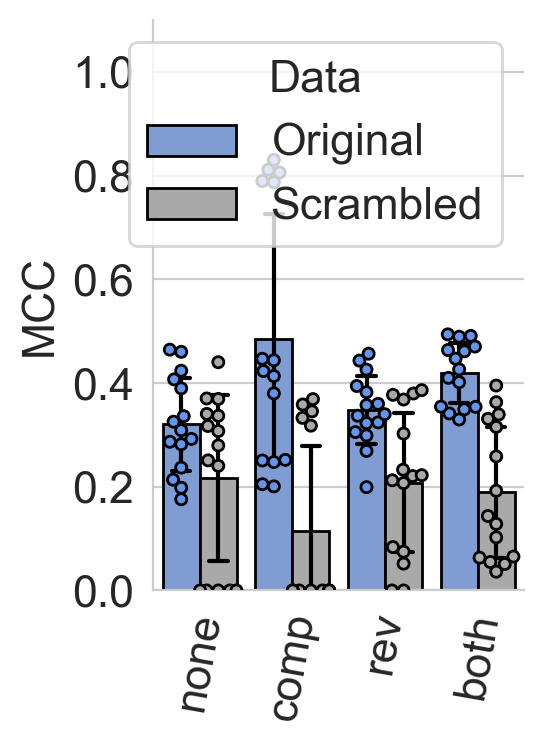

In [134]:
# load in promoters
data_path = '../exemplars/fig2/'

for seq_type in ['promoters/', 'promoters_COMP_aug/', 'promoters_REVCOMP_aug/', 'promoters_BOTHCOMP_aug/']:
    try:
        df = calc_mcc(data_path, seq_type, 'all values of MCC Class 0')
    except Exception as e:
        print(e)
        continue
    if seq_type == 'promoters/':
        wholedf = df
        wholedf['augtype'] = ['none'] * len(df)
    elif seq_type == 'promoters_COMP_aug/':
        df['augtype'] = ['comp'] * len(df)
        wholedf = pd.concat([wholedf, df])
    elif seq_type == 'promoters_REVCOMP_aug/':
        df['augtype'] = ['rev'] * len(df)
        wholedf = pd.concat([wholedf, df])
    elif seq_type == 'promoters_BOTHCOMP_aug/':
        df['augtype'] = ['both'] * len(df)
        wholedf = pd.concat([wholedf, df])
wholedf
plot_barplot_aug_type(wholedf, '../clean_figs/fig2/COMP_aug_promoters_mcc.svg', 'MCC') 

In [135]:
def plot_scatter_plot_aug_type(mcc, savepath, yaxis):
    mcc = reshape_aug_type(mcc)  
    plt.figure(figsize=(3,4), dpi=200)
    
    font = {'size'   : 24}
    matplotlib.rc('font', **font)
    my_pal = {"Original": "cornflowerblue", "Scrambled": "darkgrey"}
    
    ax = sns.catplot(x = 'Augmentation', y = 'MCC', hue = 'Data', kind = 'swarm', col = 'Model', dodge = True, data=mcc, edgecolor='black', alpha = 1, linewidth = 1, s = 10, palette = my_pal, legend = False)
    plt.legend(loc='upper right')
    #sns.catplot(x = 'augtype', y = 'values', hue = 'scr', kind = 'box', col = 'model_type', dodge = True, data=mcc, alpha = 1, linewidth = 1, s = 10, palette = my_pal)

    #handles, labels = ax.get_legend_handles_labels()
    #ax.legend(handles[2:4], labels[2:4], title='Data')
    #ax.legend()
    # Define some hatches
    #hatches = ['//', '']

    # Loop over the bars
    #for i,thisbar in enumerate(ax.patches):
    #    # Set a different hatch for each bar
    #    thisbar.set_hatch(hatches[i % len(hatches)])
    plt.xlabel('')
    plt.xticks(rotation = 0)
    plt.ylabel(yaxis)
    plt.ylim([0, 1.1])
    plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    #ax.spines['right'].set_visible(False)
    #ax.spines['top'].set_visible(False)
    plt.tight_layout()
    plt.savefig(savepath)
    plt.show()

/anaconda2/envs/automl_py37/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 40.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/anaconda2/envs/automl_py37/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/anaconda2/envs/automl_py37/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/anaconda2/envs/automl_py37/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/anaconda2/envs/automl_py37/lib/python3.7/site-packa

<Figure size 600x800 with 0 Axes>

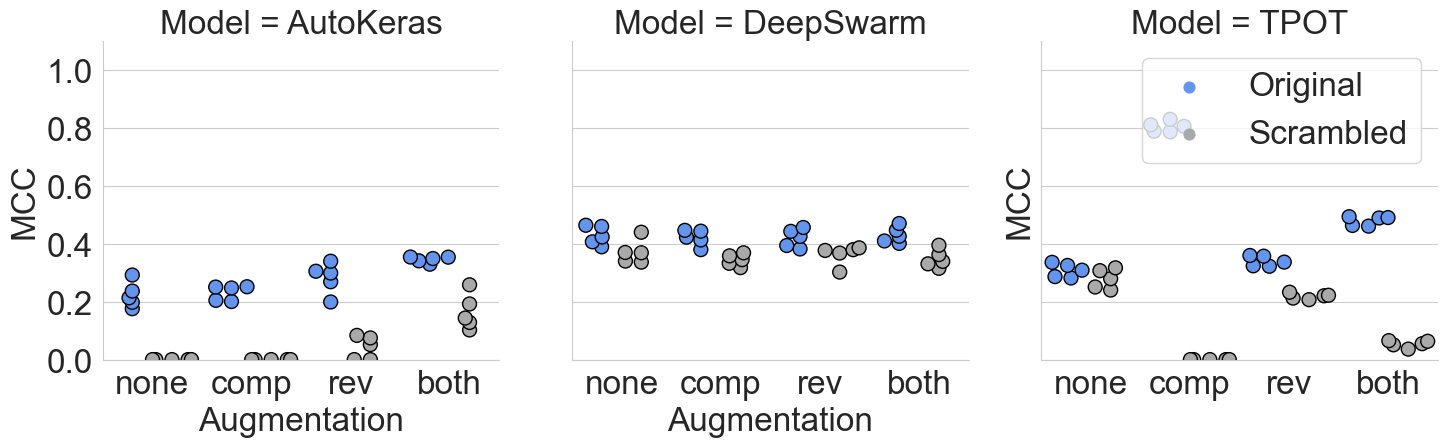

In [136]:
plot_scatter_plot_aug_type(wholedf, '../clean_figs/fig2/COMP_aug_promoters_mcc.png', 'MCC') 

Running statistics now...
AutoKeras
Ttest_indResult(statistic=54.50919971045782, pvalue=1.4231660455590026e-11)
DeepSwarm
Ttest_indResult(statistic=16.638118689765427, pvalue=1.7212022873720275e-07)
TPOT
Ttest_indResult(statistic=81.28786074695515, pvalue=5.849526373565125e-13)
Running statistics now...
AutoKeras
Ttest_indResult(statistic=84.17037866845814, pvalue=4.427711267797087e-13)
DeepSwarm
Ttest_indResult(statistic=27.0592849430944, pvalue=3.747109509197775e-09)
TPOT
Ttest_indResult(statistic=34.9012265710537, pvalue=4.968866048922187e-10)
Running statistics now...
AutoKeras
Ttest_indResult(statistic=96.20710961810211, pvalue=1.5212826975646685e-13)
DeepSwarm
Ttest_indResult(statistic=59.74529529345392, pvalue=6.8436555002803764e-12)
TPOT
Ttest_indResult(statistic=103.49869042626865, pvalue=8.483439730632932e-14)
Running statistics now...
AutoKeras
Ttest_indResult(statistic=118.7033496831031, pvalue=2.8354814217831656e-14)
DeepSwarm
Ttest_indResult(statistic=25.72353494027945, p

/anaconda2/envs/automl_py37/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/anaconda2/envs/automl_py37/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 40.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/anaconda2/envs/automl_py37/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/anaconda2/envs/automl_py37/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 40.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/anaconda2/envs/automl_py37/lib/python3.7/site-packa

<Figure size 600x800 with 0 Axes>

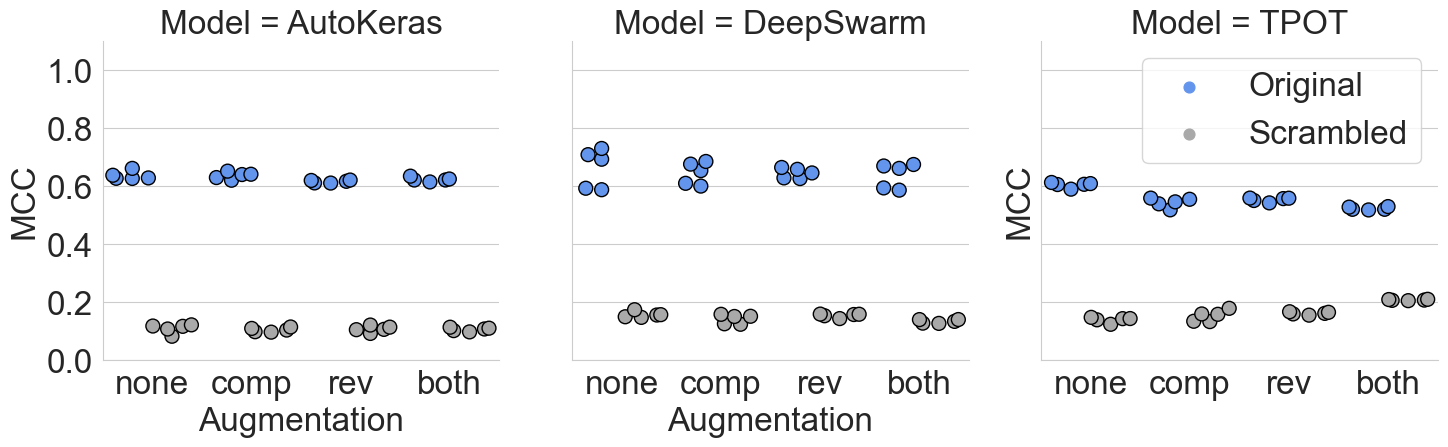

/anaconda2/envs/automl_py37/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/anaconda2/envs/automl_py37/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 40.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/anaconda2/envs/automl_py37/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/anaconda2/envs/automl_py37/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 40.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/anaconda2/envs/automl_py37/lib/python3.7/site-packa

<Figure size 600x800 with 0 Axes>

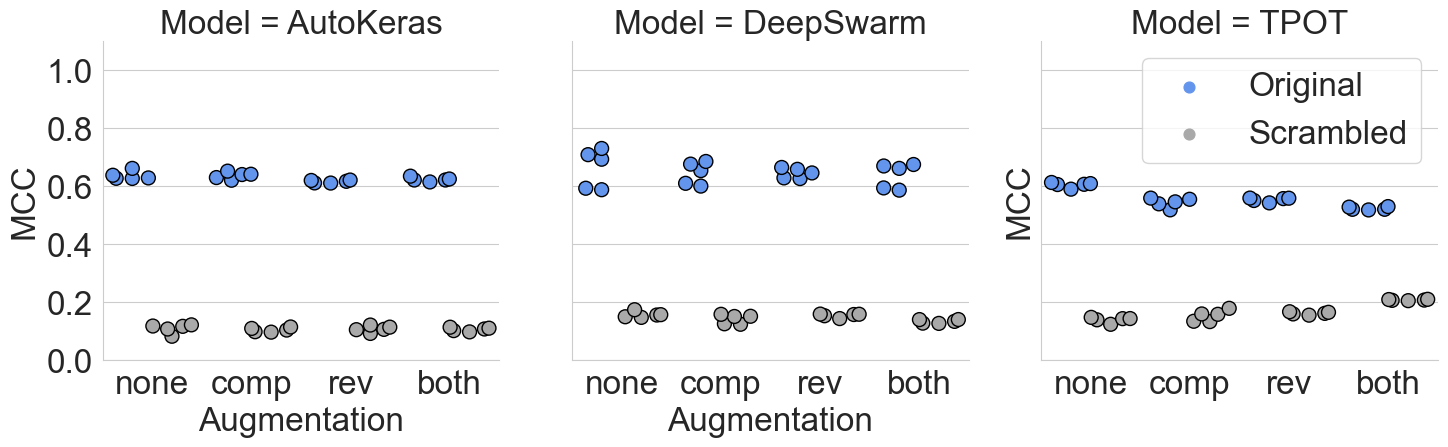

In [137]:
# load in toeholds
data_path = '../exemplars/fig2/'

for seq_type in ['toeholds/', 'toeholds_COMP_aug/', 'toeholds_REVCOMP_aug/', 'toeholds_BOTHCOMP_aug/']:
    df = calc_mcc(data_path, seq_type, 'all values of MCC Class 0')
    if seq_type == 'toeholds/':
        wholedf = df
        wholedf['augtype'] = ['none'] * len(df)
    elif seq_type == 'toeholds_COMP_aug/':
        df['augtype'] = ['comp'] * len(df)
        wholedf = pd.concat([wholedf, df])
    elif seq_type == 'toeholds_REVCOMP_aug/':
        df['augtype'] = ['rev'] * len(df)
        wholedf = pd.concat([wholedf, df])
    elif seq_type == 'toeholds_BOTHCOMP_aug/':
        df['augtype'] = ['both'] * len(df)
        wholedf = pd.concat([wholedf, df])
plot_scatter_plot_aug_type(wholedf, '../clean_figs/fig2/COMP_aug_toeholds_mcc.png', 'MCC')
plot_scatter_plot_aug_type(wholedf, '../clean_figs/fig2/COMP_aug_toeholds_mcc.svg', 'MCC')


Running statistics now...
AutoKeras
Ttest_indResult(statistic=31.68329466753562, pvalue=1.071923893280784e-09)
DeepSwarm
Ttest_indResult(statistic=12.92230815177528, pvalue=1.2170402533627994e-06)
TPOT
Ttest_indResult(statistic=10.250611348068887, pvalue=7.053867068116958e-06)
Running statistics now...
AutoKeras
Ttest_indResult(statistic=4.846165837755781, pvalue=0.0012780678213364029)
DeepSwarm
Ttest_indResult(statistic=14.015858428492091, pvalue=6.513755887337975e-07)
TPOT
Ttest_indResult(statistic=26.281090627342458, pvalue=4.721331305079878e-09)
Running statistics now...
AutoKeras
Ttest_indResult(statistic=7.125257075514751, pvalue=9.94838214687815e-05)
DeepSwarm
Ttest_indResult(statistic=12.168309699822471, pvalue=1.927835656246785e-06)
TPOT
Ttest_indResult(statistic=12.234965657734131, pvalue=1.8491062674457758e-06)
Running statistics now...
AutoKeras
Ttest_indResult(statistic=12.359312749568643, pvalue=1.7116678085726734e-06)
DeepSwarm
Ttest_indResult(statistic=8.40155200868787,

/anaconda2/envs/automl_py37/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/anaconda2/envs/automl_py37/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 40.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/anaconda2/envs/automl_py37/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/anaconda2/envs/automl_py37/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<Figure size 600x800 with 0 Axes>

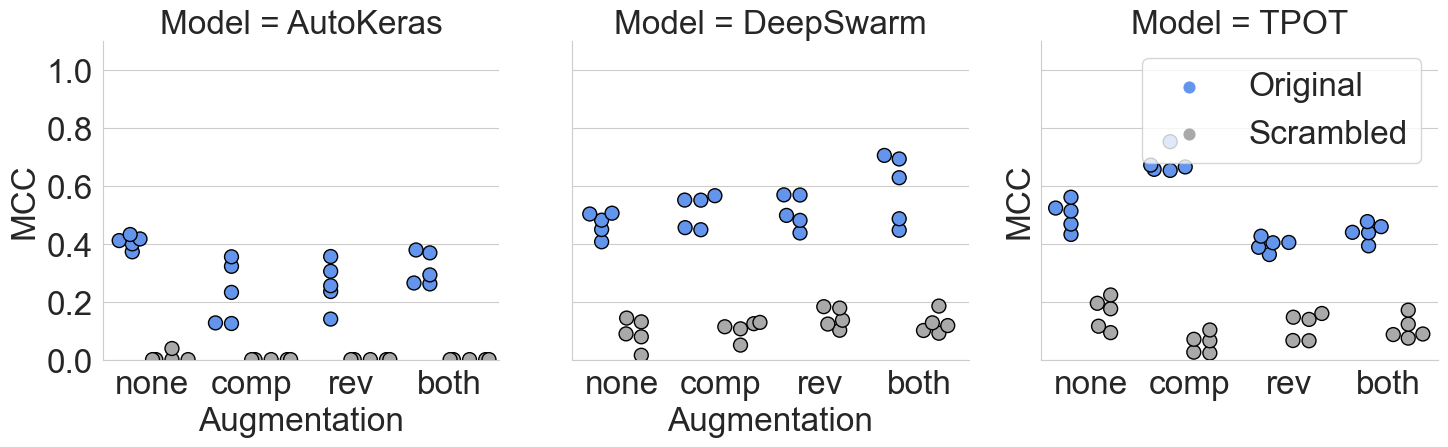

/anaconda2/envs/automl_py37/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/anaconda2/envs/automl_py37/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 40.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/anaconda2/envs/automl_py37/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/anaconda2/envs/automl_py37/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<Figure size 600x800 with 0 Axes>

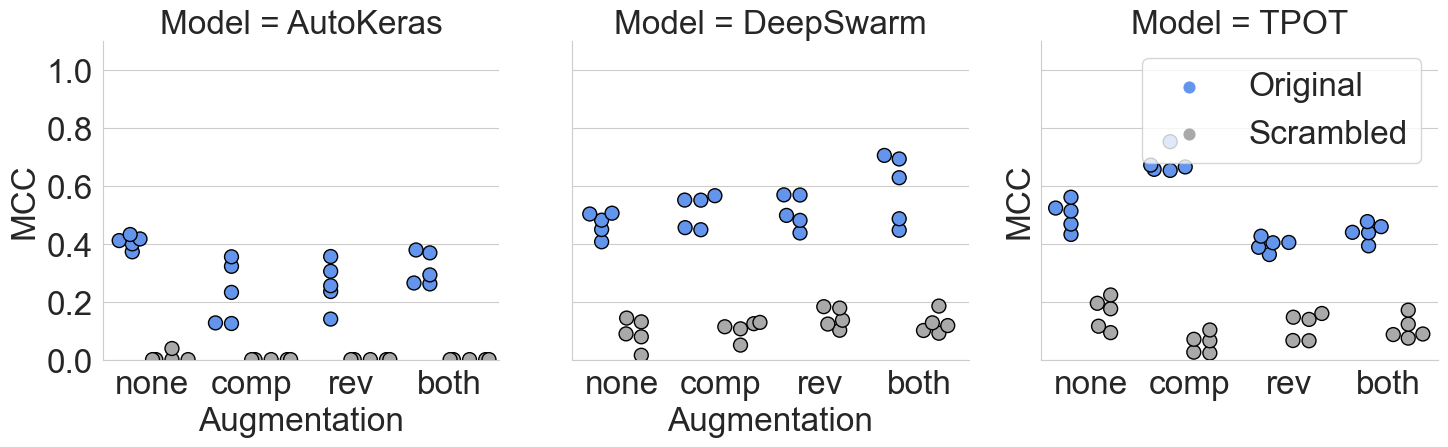

In [138]:
# load in toeholds
data_path = '../exemplars/fig2/'

for seq_type in ['toeholds_small_no_aug/', 'toeholds_small_COMP_aug/', 'toeholds_small_REVCOMP_aug/', 'toeholds_small_BOTHCOMP_aug/']:
    df = calc_mcc(data_path, seq_type, 'all values of MCC Class 0')
    if seq_type == 'toeholds_small_no_aug/':
        wholedf = df
        wholedf['augtype'] = ['none'] * len(df)
    elif seq_type == 'toeholds_small_COMP_aug/':
        df['augtype'] = ['comp'] * len(df)
        wholedf = pd.concat([wholedf, df])
    elif seq_type == 'toeholds_small_REVCOMP_aug/':
        df['augtype'] = ['rev'] * len(df)
        wholedf = pd.concat([wholedf, df])
    elif seq_type == 'toeholds_small_BOTHCOMP_aug/':
        df['augtype'] = ['both'] * len(df)
        wholedf = pd.concat([wholedf, df])
plot_scatter_plot_aug_type(wholedf, '../clean_figs/fig2/COMP_aug_smaller_starting_pt_toeholds_mcc.png', 'MCC') 
plot_scatter_plot_aug_type(wholedf, '../clean_figs/fig2/COMP_aug_smaller_starting_pt_toeholds_mcc.svg', 'MCC') 

